# Read & interpret dataset

Loading some datasets <p>
Confirming and interpreting it <p>
Preprocessing missing values and outliers on the datasets

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pathlib
import glob
import math
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

# Show all the rows and columns up to 200
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
all_data = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/all_data.csv', sep=',', header=0)

In [3]:
all_data.head()

,Date,HH,Open,High,Low,Close,Average,Volume(MWh/h),Volume(Tick count),Time,System_price(Yen/kWh),Price_Hokkaido(Yen/kWh),Price_Tokyo(Yen/kWh),Price_Kansai(Yen/kWh),BidExceed_diff,HourlyDemand_Hokkaido,HourlyDemand_Tokyo,HourlyDemand_Kansai,HourlyDemand_Okinawa,Wind_TOH,Geothermal_TOH,PumpedStorage_TOH,Interconnection_TOH,Geothermal_HOK,Wind_HOK,Interconnection_HOK,Wind_TKO,Interconnection_TKO,Wind_CHB,Interconnection_CHB,Wind_HKU,PumpedStorage_HKU,Interconnection_HKU,Nuclear_KAN,Wind_KAN,Interconnection_KAN,Thermal_CHG,Water_CHG,Wind_CHG,Interconnection_CHG,Nuclear_SHI,Wind_SHI,Interconnection_SHI,Nuclear_KYU,Geothermal_KYU,PV_KYU,PVCurtailment_KYU,Wind_KYU,WindCurtailment_KYU,Interconnection_KYU,Thermal_OKI,Biomass_OKI,Wind_OKI,Allarea_TotalDemand,Allarea_Water,Allarea_Thermal,Allarea_Geothermal,Allarea_Biomass,Allarea_PumpedStorage,Allarea_Interconnection,Water_Ratio,Thermal_Ratio,Geothermal_Ratio,Planned_Min_flag,Planned_Max_flag,month,dayofweek,holiday
0,2016-04-01,1,7.69,7.69,7.69,7.69,7.69,0.70,1,00:00:00,6.61,8.66,6.69,6.69,0,3166.0,25547.0,12917.964,644.70,46.0,116.0,0.0,-2200.0,13.0,40.0,42.0,2.0,201.0,21.0,-331.0,12.0,0.0,-148.0,0.0,41.0,1625.0,0.0,0.0,0.0,0.0,0.0,5.0,-71.0,1782.0,145.0,0.0,0.0,44.0,0.0,-1300.0,643.0,2.0,2.0,50178.0,4897.0,45004.0,274.0,82.0,110.0,-2182.0,0.100,0.9,0.01,0.0,0.0,4,4,0
1,2016-04-01,2,7.45,7.45,7.45,7.45,7.45,0.75,0,00:30:00,6.34,8.66,6.34,6.34,0,3224.0,24940.5,12876.666,635.30,48.0,116.0,0.0,-2189.0,13.0,37.0,51.5,2.0,193.5,24.5,-403.5,10.5,0.0,-79.0,0.0,32.5,1701.5,0.0,0.0,0.0,0.0,0.0,5.0,-71.0,1782.0,145.0,0.0,0.0,39.5,0.0,-1298.0,634.0,2.0,2.5,50323.5,4821.0,45204.0,274.0,81.5,55.0,-2094.0,0.095,0.9,0.01,0.0,0.0,4,4,0
2,2016-04-01,3,7.21,7.21,7.21,7.21,7.21,0.80,1,01:00:00,6.34,7.20,6.34,6.34,0,3282.0,24334.0,12835.368,625.90,50.0,116.0,0.0,-2178.0,13.0,34.0,61.0,2.0,186.0,28.0,-476.0,9.0,0.0,-10.0,0.0,24.0,1778.0,0.0,0.0,0.0,0.0,0.0,5.0,-71.0,1782.0,145.0,0.0,0.0,35.0,0.0,-1296.0,625.0,2.0,3.0,50469.0,4745.0,45404.0,274.0,81.0,0.0,-2006.0,0.090,0.9,0.01,0.0,0.0,4,4,0
3,2016-04-01,4,7.06,7.06,7.06,7.06,7.06,0.80,1,01:30:00,6.25,7.10,6.03,6.03,0,3334.5,24134.0,13093.248,632.75,49.0,115.5,0.0,-2174.5,13.0,31.5,60.0,2.0,183.0,35.0,-485.5,8.5,0.0,-38.5,0.0,25.5,1811.0,0.0,0.0,0.0,0.0,0.0,5.0,-69.0,1781.5,145.0,0.0,0.0,39.0,0.0,-1360.0,632.5,2.0,2.5,51340.0,4868.5,46207.0,273.5,80.0,6.0,-2073.5,0.095,0.9,0.01,0.0,0.0,4,4,0
4,2016-04-01,5,7.21,7.21,7.21,7.21,7.21,0.80,1,02:00:00,6.57,7.10,6.57,6.57,0,3387.0,23934.0,13351.128,639.60,48.0,115.0,0.0,-2171.0,13.0,29.0,59.0,2.0,180.0,42.0,-495.0,8.0,0.0,-67.0,0.0,27.0,1844.0,0.0,0.0,0.0,0.0,0.0,5.0,-67.0,1781.0,145.0,0.0,0.0,43.0,0.0,-1424.0,640.0,2.0,2.0,52211.0,4992.0,47010.0,273.0,79.0,12.0,-2141.0,0.100,0.9,0.01,1.0,0.0,4,4,0


# Data leakage(Predictionポイントは前日の24:00とする)

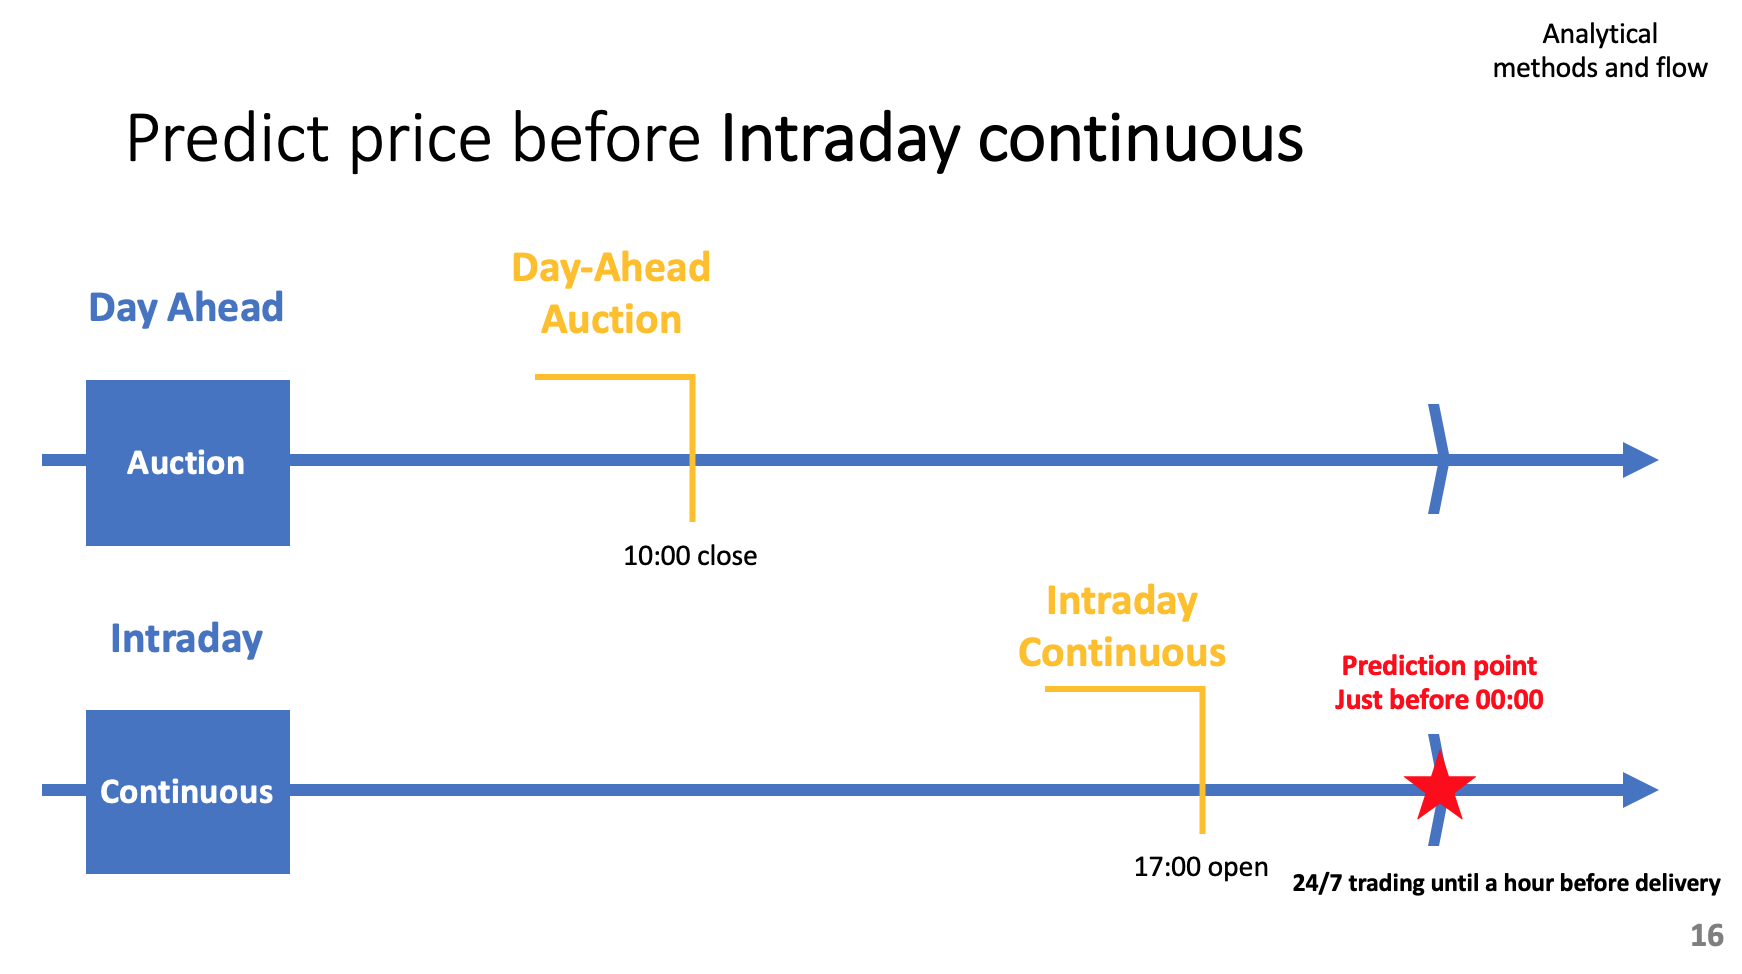

予測時点でどの特徴量が存在しうるか整理する

- Close priceは外す (Target) 
- Spot_price & volume: そのまま(Spot価格確定後の予測)
- 電力需要ピーク情報: そのまま（翌日予測）
- その他: <p>
    ※本来は block_date_numを2日分ずらす必要がある<p>
        ※ここでの論点はIntraday開始直後に取引される17:00から24:00までのアイテムが１日ずらしではつかえないということ。つまり、17:00-24:00を勘案すると2日ずらす必要がある。(今後調整するかも) <p>
    --> もし１日ずらしであれば0:00〜1:00あたりの取引が不利になる可能性有り　--> 1daylagと2daylagの予測精度を見てみて、改善が見られれば予測精度を取るべき(17:00~24:00のアイテムの深夜取引は限定的と仮定する)
    ①block_date_numを１日もしくは２日ずらす
    その上で更に、直前のスロットの情報は相関が高いので<p>
    ② HHを1スロット分ずらす <p>
    ③ その他はseasonality検証後に必要に応じて追加 <p>
    ④ lag_feature生成後元の特徴量は全て削除 <p>

# Feature Engineering

## Moving average/VWAP

[Moving average only for System price]

In [4]:
# Moving average for System price (Do not need lag) 1month, 3month, 1year
all_data["Spot_MA25d"] = all_data["System_price(Yen/kWh)"].rolling(1200).mean().round(2)
all_data["Spot_MA75d"] = all_data["System_price(Yen/kWh)"].rolling(3600).mean().round(2)
all_data["Spot_MA200d"] = all_data["System_price(Yen/kWh)"].rolling(9600).mean().round(2)

[VWAP]

(Reference)
MWh/hについて：https://www.jstage.jst.go.jp/article/ieejpes/127/4/127_4_573/_pdf/-char/ja

In [5]:
# Adjust unit from MWh to kWh
all_data['Volume_kWh'] = (all_data['Volume(MWh/h)']/2)*1000
all_data['Cum_Vol'] = all_data['Volume_kWh'].cumsum()
all_data['Cum_Vol_Price'] = (all_data['Volume_kWh'] * all_data['Average'] ).cumsum()
all_data['VWAP'] = all_data['Cum_Vol_Price'] / all_data['Cum_Vol']
all_data = all_data.drop(["Volume_kWh", "Cum_Vol", "Cum_Vol_Price"], axis=1)

In [6]:
all_data = all_data.fillna(0)
all_data.isnull().sum()

Date                       0
HH                         0
Open                       0
High                       0
Low                        0
Close                      0
Average                    0
Volume(MWh/h)              0
Volume(Tick count)         0
Time                       0
System_price(Yen/kWh)      0
Price_Hokkaido(Yen/kWh)    0
Price_Tokyo(Yen/kWh)       0
Price_Kansai(Yen/kWh)      0
BidExceed_diff             0
HourlyDemand_Hokkaido      0
HourlyDemand_Tokyo         0
HourlyDemand_Kansai        0
HourlyDemand_Okinawa       0
Wind_TOH                   0
Geothermal_TOH             0
PumpedStorage_TOH          0
Interconnection_TOH        0
Geothermal_HOK             0
Wind_HOK                   0
Interconnection_HOK        0
Wind_TKO                   0
Interconnection_TKO        0
Wind_CHB                   0
Interconnection_CHB        0
Wind_HKU                   0
PumpedStorage_HKU          0
Interconnection_HKU        0
Nuclear_KAN                0
Wind_KAN      

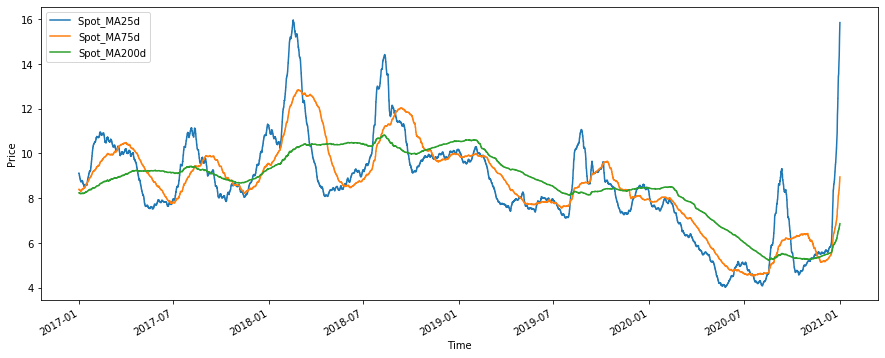

In [7]:
# plot the moving average
fig, ax = plt.subplots(1, figsize=(15, 6))

graph = all_data.copy()
graph["DateTime"] = pd.to_datetime(graph["Date"].astype(str) + " " + graph["Time"].astype(str))

# Set index
graph = graph.set_index("DateTime")
start = "2017-01-01 00:00:00"
end = "2020-12-31 23:30:00"

# Plot Close 
graph.Spot_MA25d [graph.index > start].plot(ax=ax, label="Spot_MA25d ")
graph.Spot_MA75d[graph.index > start].plot(ax=ax, label="Spot_MA75d")
graph.Spot_MA200d[graph.index > start].plot(ax=ax, label="Spot_MA200d")

# x-axis
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Price")
plt.legend(loc="upper left");

## Lag-features (Avoiding data leakage)

※Infinity value will be happen with Downcast preprocessing. ("Total" column)

In [8]:
# Check the remaining memory on PC
import gc
gc.collect()

37

※ ラグ特徴量が必要ないものは外す
-->Closeラグ特徴量を生成し、元データとラグ特徴量の両方を残す

In [9]:
# This is for generating lag
def generate_lag(train, lag_sizes, cols, lag_sizes_type):

    lag_sizes = np.array(lag_sizes)
    if lag_sizes_type == "HH":
        lag_sizes_adj = lag_sizes * 1 # nothing changes
    elif lag_sizes_type == "Hours":
        lag_sizes_adj = lag_sizes * 2
    elif lag_sizes_type == "Day":
        lag_sizes_adj = lag_sizes * 48

    for ix, lag_sizes_adj_ in enumerate(lag_sizes_adj):
        shifted_df = all_data[cols].shift(lag_sizes_adj_)
        shifted_df.columns = [f"{col_name}_lag_{lag_sizes[ix]}_{lag_sizes_type}" for col_name in shifted_df.columns]
        if ix == 0:
            shifted_df_return = shifted_df
        else:
            shifted_df_return = shifted_df_return.merge(shifted_df, how="left", left_index=True, right_index=True)
    return shifted_df_return

In [10]:
all_data.columns

Index(['Date', 'HH', 'Open', 'High', 'Low', 'Close', 'Average',
       'Volume(MWh/h)', 'Volume(Tick count)', 'Time', 'System_price(Yen/kWh)',
       'Price_Hokkaido(Yen/kWh)', 'Price_Tokyo(Yen/kWh)',
       'Price_Kansai(Yen/kWh)', 'BidExceed_diff', 'HourlyDemand_Hokkaido',
       'HourlyDemand_Tokyo', 'HourlyDemand_Kansai', 'HourlyDemand_Okinawa',
       'Wind_TOH', 'Geothermal_TOH', 'PumpedStorage_TOH',
       'Interconnection_TOH', 'Geothermal_HOK', 'Wind_HOK',
       'Interconnection_HOK', 'Wind_TKO', 'Interconnection_TKO', 'Wind_CHB',
       'Interconnection_CHB', 'Wind_HKU', 'PumpedStorage_HKU',
       'Interconnection_HKU', 'Nuclear_KAN', 'Wind_KAN', 'Interconnection_KAN',
       'Thermal_CHG', 'Water_CHG', 'Wind_CHG', 'Interconnection_CHG',
       'Nuclear_SHI', 'Wind_SHI', 'Interconnection_SHI', 'Nuclear_KYU',
       'Geothermal_KYU', 'PV_KYU', 'PVCurtailment_KYU', 'Wind_KYU',
       'WindCurtailment_KYU', 'Interconnection_KYU', 'Thermal_OKI',
       'Biomass_OKI', 'Wind_OKI'

In [11]:
# Drop columns that are not necessary to generate lag features
lag_columns = all_data.columns.drop(['Date', 'Time', 'HH', 'System_price(Yen/kWh)', 'Price_Hokkaido(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 
       'Price_Kansai(Yen/kWh)', 'BidExceed_diff', 'Planned_Min_flag', 'Planned_Max_flag', 'month', 
       'dayofweek', 'holiday', 'Spot_MA25d', 'Spot_MA75d', 'Spot_MA200d'])

# Generate lag features and drop original columns
# all_data_lagged_HH = generate_lag(all_data, [49, 97], lag_columns, "HH")
# all_data_lagged_Hour = generate_lag(all_data, [2], lag_columns, "Hours")
all_data_lagged_Day = generate_lag(all_data, [1, 2], lag_columns, "Day")

# join everything
# all_data_lagged = pd.merge(all_data, all_data_lagged_HH, how="left", left_index=True, right_index=True)
# all_data = pd.merge(all_data, all_data_lagged_Hour, how="left", left_index=True, right_index=True)
all_data_lagged = pd.merge(all_data, all_data_lagged_Day, how="left", left_index=True, right_index=True)

# Drop lag_columns which can be data leakage
all_data_lagged = all_data_lagged.drop(lag_columns, axis=1)

# Keep both the original and lagged "Close" --> Original: target / Lagged: feature
all_data_lagged["Close"] = all_data["Close"]

In [12]:
all_data_lagged.head()

,Date,HH,Time,System_price(Yen/kWh),Price_Hokkaido(Yen/kWh),Price_Tokyo(Yen/kWh),Price_Kansai(Yen/kWh),BidExceed_diff,Planned_Min_flag,Planned_Max_flag,month,dayofweek,holiday,Spot_MA25d,Spot_MA75d,Spot_MA200d,Open_lag_1_Day,High_lag_1_Day,Low_lag_1_Day,Close_lag_1_Day,Average_lag_1_Day,Volume(MWh/h)_lag_1_Day,Volume(Tick count)_lag_1_Day,HourlyDemand_Hokkaido_lag_1_Day,HourlyDemand_Tokyo_lag_1_Day,HourlyDemand_Kansai_lag_1_Day,HourlyDemand_Okinawa_lag_1_Day,Wind_TOH_lag_1_Day,Geothermal_TOH_lag_1_Day,PumpedStorage_TOH_lag_1_Day,Interconnection_TOH_lag_1_Day,Geothermal_HOK_lag_1_Day,Wind_HOK_lag_1_Day,Interconnection_HOK_lag_1_Day,Wind_TKO_lag_1_Day,Interconnection_TKO_lag_1_Day,Wind_CHB_lag_1_Day,Interconnection_CHB_lag_1_Day,Wind_HKU_lag_1_Day,PumpedStorage_HKU_lag_1_Day,Interconnection_HKU_lag_1_Day,Nuclear_KAN_lag_1_Day,Wind_KAN_lag_1_Day,Interconnection_KAN_lag_1_Day,Thermal_CHG_lag_1_Day,Water_CHG_lag_1_Day,Wind_CHG_lag_1_Day,Interconnection_CHG_lag_1_Day,Nuclear_SHI_lag_1_Day,Wind_SHI_lag_1_Day,Interconnection_SHI_lag_1_Day,Nuclear_KYU_lag_1_Day,Geothermal_KYU_lag_1_Day,PV_KYU_lag_1_Day,PVCurtailment_KYU_lag_1_Day,Wind_KYU_lag_1_Day,WindCurtailment_KYU_lag_1_Day,Interconnection_KYU_lag_1_Day,Thermal_OKI_lag_1_Day,Biomass_OKI_lag_1_Day,Wind_OKI_lag_1_Day,Allarea_TotalDemand_lag_1_Day,Allarea_Water_lag_1_Day,Allarea_Thermal_lag_1_Day,Allarea_Geothermal_lag_1_Day,Allarea_Biomass_lag_1_Day,Allarea_PumpedStorage_lag_1_Day,Allarea_Interconnection_lag_1_Day,Water_Ratio_lag_1_Day,Thermal_Ratio_lag_1_Day,Geothermal_Ratio_lag_1_Day,VWAP_lag_1_Day,Open_lag_2_Day,High_lag_2_Day,Low_lag_2_Day,Close_lag_2_Day,Average_lag_2_Day,Volume(MWh/h)_lag_2_Day,Volume(Tick count)_lag_2_Day,HourlyDemand_Hokkaido_lag_2_Day,HourlyDemand_Tokyo_lag_2_Day,HourlyDemand_Kansai_lag_2_Day,HourlyDemand_Okinawa_lag_2_Day,Wind_TOH_lag_2_Day,Geothermal_TOH_lag_2_Day,PumpedStorage_TOH_lag_2_Day,Interconnection_TOH_lag_2_Day,Geothermal_HOK_lag_2_Day,Wind_HOK_lag_2_Day,Interconnection_HOK_lag_2_Day,Wind_TKO_lag_2_Day,Interconnection_TKO_lag_2_Day,Wind_CHB_lag_2_Day,Interconnection_CHB_lag_2_Day,Wind_HKU_lag_2_Day,PumpedStorage_HKU_lag_2_Day,Interconnection_HKU_lag_2_Day,Nuclear_KAN_lag_2_Day,Wind_KAN_lag_2_Day,Interconnection_KAN_lag_2_Day,Thermal_CHG_lag_2_Day,Water_CHG_lag_2_Day,Wind_CHG_lag_2_Day,Interconnection_CHG_lag_2_Day,Nuclear_SHI_lag_2_Day,Wind_SHI_lag_2_Day,Interconnection_SHI_lag_2_Day,Nuclear_KYU_lag_2_Day,Geothermal_KYU_lag_2_Day,PV_KYU_lag_2_Day,PVCurtailment_KYU_lag_2_Day,Wind_KYU_lag_2_Day,WindCurtailment_KYU_lag_2_Day,Interconnection_KYU_lag_2_Day,Thermal_OKI_lag_2_Day,Biomass_OKI_lag_2_Day,Wind_OKI_lag_2_Day,Allarea_TotalDemand_lag_2_Day,Allarea_Water_lag_2_Day,Allarea_Thermal_lag_2_Day,Allarea_Geothermal_lag_2_Day,Allarea_Biomass_lag_2_Day,Allarea_PumpedStorage_lag_2_Day,Allarea_Interconnection_lag_2_Day,Water_Ratio_lag_2_Day,Thermal_Ratio_lag_2_Day,Geothermal_Ratio_lag_2_Day,VWAP_lag_2_Day,Close
0,2016-04-01,1,00:00:00,6.61,8.66,6.69,6.69,0,0.0,0.0,4,4,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.69
1,2016-04-01,2,00:30:00,6.34,8.66,6.34,6.34,0,0.0,0.0,4,4,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.45
2,2016-04-01,3

In [13]:
# Check the lag columns
# temp_col = [item for item in all_data.columns if item.find('Day') != -1]

# print(temp_col)

NaN was generated only on 96 (48 * 2) timeslots on the firstday 2016/04/01　and 2016/04/02 --> OK 

In [14]:
all_data_lagged.shape

(83237, 129)

In [15]:
all_data_lagged.fillna(0, inplace=True)
print(all_data_lagged.isnull().sum())

Date                                 0
HH                                   0
Time                                 0
System_price(Yen/kWh)                0
Price_Hokkaido(Yen/kWh)              0
Price_Tokyo(Yen/kWh)                 0
Price_Kansai(Yen/kWh)                0
BidExceed_diff                       0
Planned_Min_flag                     0
Planned_Max_flag                     0
month                                0
dayofweek                            0
holiday                              0
Spot_MA25d                           0
Spot_MA75d                           0
Spot_MA200d                          0
Open_lag_1_Day                       0
High_lag_1_Day                       0
Low_lag_1_Day                        0
Close_lag_1_Day                      0
Average_lag_1_Day                    0
Volume(MWh/h)_lag_1_Day              0
Volume(Tick count)_lag_1_Day         0
HourlyDemand_Hokkaido_lag_1_Day      0
HourlyDemand_Tokyo_lag_1_Day         0
HourlyDemand_Kansai_lag_1

In [16]:
all_data_lagged.tail()

,Date,HH,Time,System_price(Yen/kWh),Price_Hokkaido(Yen/kWh),Price_Tokyo(Yen/kWh),Price_Kansai(Yen/kWh),BidExceed_diff,Planned_Min_flag,Planned_Max_flag,month,dayofweek,holiday,Spot_MA25d,Spot_MA75d,Spot_MA200d,Open_lag_1_Day,High_lag_1_Day,Low_lag_1_Day,Close_lag_1_Day,Average_lag_1_Day,Volume(MWh/h)_lag_1_Day,Volume(Tick count)_lag_1_Day,HourlyDemand_Hokkaido_lag_1_Day,HourlyDemand_Tokyo_lag_1_Day,HourlyDemand_Kansai_lag_1_Day,HourlyDemand_Okinawa_lag_1_Day,Wind_TOH_lag_1_Day,Geothermal_TOH_lag_1_Day,PumpedStorage_TOH_lag_1_Day,Interconnection_TOH_lag_1_Day,Geothermal_HOK_lag_1_Day,Wind_HOK_lag_1_Day,Interconnection_HOK_lag_1_Day,Wind_TKO_lag_1_Day,Interconnection_TKO_lag_1_Day,Wind_CHB_lag_1_Day,Interconnection_CHB_lag_1_Day,Wind_HKU_lag_1_Day,PumpedStorage_HKU_lag_1_Day,Interconnection_HKU_lag_1_Day,Nuclear_KAN_lag_1_Day,Wind_KAN_lag_1_Day,Interconnection_KAN_lag_1_Day,Thermal_CHG_lag_1_Day,Water_CHG_lag_1_Day,Wind_CHG_lag_1_Day,Interconnection_CHG_lag_1_Day,Nuclear_SHI_lag_1_Day,Wind_SHI_lag_1_Day,Interconnection_SHI_lag_1_Day,Nuclear_KYU_lag_1_Day,Geothermal_KYU_lag_1_Day,PV_KYU_lag_1_Day,PVCurtailment_KYU_lag_1_Day,Wind_KYU_lag_1_Day,WindCurtailment_KYU_lag_1_Day,Interconnection_KYU_lag_1_Day,Thermal_OKI_lag_1_Day,Biomass_OKI_lag_1_Day,Wind_OKI_lag_1_Day,Allarea_TotalDemand_lag_1_Day,Allarea_Water_lag_1_Day,Allarea_Thermal_lag_1_Day,Allarea_Geothermal_lag_1_Day,Allarea_Biomass_lag_1_Day,Allarea_PumpedStorage_lag_1_Day,Allarea_Interconnection_lag_1_Day,Water_Ratio_lag_1_Day,Thermal_Ratio_lag_1_Day,Geothermal_Ratio_lag_1_Day,VWAP_lag_1_Day,Open_lag_2_Day,High_lag_2_Day,Low_lag_2_Day,Close_lag_2_Day,Average_lag_2_Day,Volume(MWh/h)_lag_2_Day,Volume(Tick count)_lag_2_Day,HourlyDemand_Hokkaido_lag_2_Day,HourlyDemand_Tokyo_lag_2_Day,HourlyDemand_Kansai_lag_2_Day,HourlyDemand_Okinawa_lag_2_Day,Wind_TOH_lag_2_Day,Geothermal_TOH_lag_2_Day,PumpedStorage_TOH_lag_2_Day,Interconnection_TOH_lag_2_Day,Geothermal_HOK_lag_2_Day,Wind_HOK_lag_2_Day,Interconnection_HOK_lag_2_Day,Wind_TKO_lag_2_Day,Interconnection_TKO_lag_2_Day,Wind_CHB_lag_2_Day,Interconnection_CHB_lag_2_Day,Wind_HKU_lag_2_Day,PumpedStorage_HKU_lag_2_Day,Interconnection_HKU_lag_2_Day,Nuclear_KAN_lag_2_Day,Wind_KAN_lag_2_Day,Interconnection_KAN_lag_2_Day,Thermal_CHG_lag_2_Day,Water_CHG_lag_2_Day,Wind_CHG_lag_2_Day,Interconnection_CHG_lag_2_Day,Nuclear_SHI_lag_2_Day,Wind_SHI_lag_2_Day,Interconnection_SHI_lag_2_Day,Nuclear_KYU_lag_2_Day,Geothermal_KYU_lag_2_Day,PV_KYU_lag_2_Day,PVCurtailment_KYU_lag_2_Day,Wind_KYU_lag_2_Day,WindCurtailment_KYU_lag_2_Day,Interconnection_KYU_lag_2_Day,Thermal_OKI_lag_2_Day,Biomass_OKI_lag_2_Day,Wind_OKI_lag_2_Day,Allarea_TotalDemand_lag_2_Day,Allarea_Water_lag_2_Day,Allarea_Thermal_lag_2_Day,Allarea_Geothermal_lag_2_Day,Allarea_Biomass_lag_2_Day,Allarea_PumpedStorage_lag_2_Day,Allarea_Interconnection_lag_2_Day,Water_Ratio_lag_2_Day,Thermal_Ratio_lag_2_Day,Geothermal_Ratio_lag_2_Day,VWAP_lag_2_Day,Close
83232,2020-12-31,44,21:30:00,35.0,35.0,35.0,50.0,0,0.0,0.0,12,3,0,15.75,8.91,6.85,50.00,55.00,30.00,30.00,43.81,475.7,190.0,4243.0,33324.0,16495.816,846.85,1042.5,149.5,0.0,-4548.0,13.5,148.5,33.5,32.0,417.5,127.5,292.0,106.0,0.0,-287.0,0.0,58.5,2161.5,6090.0,303.0,126.0,472.0,0.0,7.5,-74.0,2987.5,174.0,0.0,0.0,255.5,0.0,-1558.0,831.85,4.60,12.30,71276.55,4409.3,62112.35,337.0,1248.10,1358.0,-3090.5,0.065,0.870,0.000,10.354732,34.00,34.00,14.90,14.90,26.38,811.7,187.0,4068.5,31534.5,14857.275,821.5,439.0,148.5,0.0,-4406.0,13.0,98.5,-62.5,20.0,493.0,8.5,-203.0,105.0,0.0,-494.0,0.0,58.5,2343.5,5058.5,190.5,19.5,612.5,0.0,13.0,-86.0,2954.5,171.0,0.0,0.0,103.5,0.0,-1865.0,816.40,4.50,0.05,62567.75,3619.8,57030.90,332.5,1245.00,186.5,-3667.5,0.055,0.915,0.01,10.323426,70.00
83233,2020-12-31,45,22:00:00,45.0,40.0,40.0,50.0,0,0.0,0.0,12,3,0,15.78,8.92,6.85,50.00,55.00,30.00,30.00,44.40,777.0,206.0,4166.0,32448.0,15995.051,821.40,1044.0,150.0,0.0,-4543.0,14.0,157.0,21.0,31.0,419.0,120.0,200.0,108.0,0.0,-194.0,0.0,58.0,2225.0,5890.0,298.0,126.0,503.0,0.0,6.

## Standardise with Log-features (対数化)

[Mission]
対数の逆対数変換をして元の数値を得ること
-->グラフで可視化してみる (Closeと対数化Close)線グラフ
-->逆対数の数式を手動で適用してみる
-->

In [17]:
all_data_lagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Columns: 129 entries, Date to Close
dtypes: float64(122), int64(5), object(2)
memory usage: 81.9+ MB


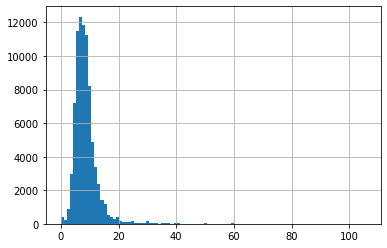

In [18]:
all_data_lagged["Close"].hist(bins=100);

Features seem to be positive skew, and have different scale. --> Need to standardise

In [19]:
all_data_lagged.columns

Index(['Date', 'HH', 'Time', 'System_price(Yen/kWh)',
       'Price_Hokkaido(Yen/kWh)', 'Price_Tokyo(Yen/kWh)',
       'Price_Kansai(Yen/kWh)', 'BidExceed_diff', 'Planned_Min_flag',
       'Planned_Max_flag',
       ...
       'Allarea_Thermal_lag_2_Day', 'Allarea_Geothermal_lag_2_Day',
       'Allarea_Biomass_lag_2_Day', 'Allarea_PumpedStorage_lag_2_Day',
       'Allarea_Interconnection_lag_2_Day', 'Water_Ratio_lag_2_Day',
       'Thermal_Ratio_lag_2_Day', 'Geothermal_Ratio_lag_2_Day',
       'VWAP_lag_2_Day', 'Close'],
      dtype='object', length=129)

In [20]:
all_data_lagged1 = all_data_lagged[['Date', 'Time', 'HH', 'month', 'dayofweek', 'holiday', 'Planned_Min_flag', 'Planned_Max_flag']]
all_data_lagged2 = all_data_lagged.drop(['Date', 'Time', 'HH', 'month', 'dayofweek', 'holiday', 'Planned_Min_flag', 'Planned_Max_flag'], axis=1)

In [21]:
# # logarithmic transformation for standardised
# # 0と負の値を含む列があるので、PowerTransformer()のYeo-Johnson変換を適用する (対数変換の一種)
from sklearn.preprocessing import PowerTransformer
def trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.transform(df2)

def inverse_trans_yeo_johnson(df, df2):
    pt = PowerTransformer() #default: Yeo-Johnson (this allow also 0-value to transform to logarithmic value)
    pt.fit_transform(df)
    return pt.inverse_transform(df2)

In [22]:
#　対数変換
all_data_log2_transformed = all_data_lagged2.copy()
cols = all_data_log2_transformed.columns

all_data_log2_transformed = trans_yeo_johnson(all_data_lagged2, all_data_log2_transformed)
all_data_log2_transformed = pd.DataFrame(all_data_log2_transformed)
all_data_log2_transformed.columns = cols

In [23]:
all_data_log = pd.concat([all_data_lagged1, all_data_log2_transformed], axis=1)

In [24]:
all_data_log.tail()

,Date,Time,HH,month,dayofweek,holiday,Planned_Min_flag,Planned_Max_flag,System_price(Yen/kWh),Price_Hokkaido(Yen/kWh),Price_Tokyo(Yen/kWh),Price_Kansai(Yen/kWh),BidExceed_diff,Spot_MA25d,Spot_MA75d,Spot_MA200d,Open_lag_1_Day,High_lag_1_Day,Low_lag_1_Day,Close_lag_1_Day,Average_lag_1_Day,Volume(MWh/h)_lag_1_Day,Volume(Tick count)_lag_1_Day,HourlyDemand_Hokkaido_lag_1_Day,HourlyDemand_Tokyo_lag_1_Day,HourlyDemand_Kansai_lag_1_Day,HourlyDemand_Okinawa_lag_1_Day,Wind_TOH_lag_1_Day,Geothermal_TOH_lag_1_Day,PumpedStorage_TOH_lag_1_Day,Interconnection_TOH_lag_1_Day,Geothermal_HOK_lag_1_Day,Wind_HOK_lag_1_Day,Interconnection_HOK_lag_1_Day,Wind_TKO_lag_1_Day,Interconnection_TKO_lag_1_Day,Wind_CHB_lag_1_Day,Interconnection_CHB_lag_1_Day,Wind_HKU_lag_1_Day,PumpedStorage_HKU_lag_1_Day,Interconnection_HKU_lag_1_Day,Nuclear_KAN_lag_1_Day,Wind_KAN_lag_1_Day,Interconnection_KAN_lag_1_Day,Thermal_CHG_lag_1_Day,Water_CHG_lag_1_Day,Wind_CHG_lag_1_Day,Interconnection_CHG_lag_1_Day,Nuclear_SHI_lag_1_Day,Wind_SHI_lag_1_Day,Interconnection_SHI_lag_1_Day,Nuclear_KYU_lag_1_Day,Geothermal_KYU_lag_1_Day,PV_KYU_lag_1_Day,PVCurtailment_KYU_lag_1_Day,Wind_KYU_lag_1_Day,WindCurtailment_KYU_lag_1_Day,Interconnection_KYU_lag_1_Day,Thermal_OKI_lag_1_Day,Biomass_OKI_lag_1_Day,Wind_OKI_lag_1_Day,Allarea_TotalDemand_lag_1_Day,Allarea_Water_lag_1_Day,Allarea_Thermal_lag_1_Day,Allarea_Geothermal_lag_1_Day,Allarea_Biomass_lag_1_Day,Allarea_PumpedStorage_lag_1_Day,Allarea_Interconnection_lag_1_Day,Water_Ratio_lag_1_Day,Thermal_Ratio_lag_1_Day,Geothermal_Ratio_lag_1_Day,VWAP_lag_1_Day,Open_lag_2_Day,High_lag_2_Day,Low_lag_2_Day,Close_lag_2_Day,Average_lag_2_Day,Volume(MWh/h)_lag_2_Day,Volume(Tick count)_lag_2_Day,HourlyDemand_Hokkaido_lag_2_Day,HourlyDemand_Tokyo_lag_2_Day,HourlyDemand_Kansai_lag_2_Day,HourlyDemand_Okinawa_lag_2_Day,Wind_TOH_lag_2_Day,Geothermal_TOH_lag_2_Day,PumpedStorage_TOH_lag_2_Day,Interconnection_TOH_lag_2_Day,Geothermal_HOK_lag_2_Day,Wind_HOK_lag_2_Day,Interconnection_HOK_lag_2_Day,Wind_TKO_lag_2_Day,Interconnection_TKO_lag_2_Day,Wind_CHB_lag_2_Day,Interconnection_CHB_lag_2_Day,Wind_HKU_lag_2_Day,PumpedStorage_HKU_lag_2_Day,Interconnection_HKU_lag_2_Day,Nuclear_KAN_lag_2_Day,Wind_KAN_lag_2_Day,Interconnection_KAN_lag_2_Day,Thermal_CHG_lag_2_Day,Water_CHG_lag_2_Day,Wind_CHG_lag_2_Day,Interconnection_CHG_lag_2_Day,Nuclear_SHI_lag_2_Day,Wind_SHI_lag_2_Day,Interconnection_SHI_lag_2_Day,Nuclear_KYU_lag_2_Day,Geothermal_KYU_lag_2_Day,PV_KYU_lag_2_Day,PVCurtailment_KYU_lag_2_Day,Wind_KYU_lag_2_Day,WindCurtailment_KYU_lag_2_Day,Interconnection_KYU_lag_2_Day,Thermal_OKI_lag_2_Day,Biomass_OKI_lag_2_Day,Wind_OKI_lag_2_Day,Allarea_TotalDemand_lag_2_Day,Allarea_Water_lag_2_Day,Allarea_Thermal_lag_2_Day,Allarea_Geothermal_lag_2_Day,Allarea_Biomass_lag_2_Day,Allarea_PumpedStorage_lag_2_Day,Allarea_Interconnection_lag_2_Day,Water_Ratio_lag_2_Day,Thermal_Ratio_lag_2_Day,Geothermal_Ratio_lag_2_Day,VWAP_lag_2_Day,Close
83232,2020-12-31,21:30:00,44,12,3,0,0.0,0.0,4.063279,2.662748,3.253262,4.812611,-0.504388,3.603386,0.243553,-0.567171,3.808611,3.019716,5.161585,3.367296,4.171711,0.964374,1.904803,1.239179,0.181169,0.047164,-0.354732,1.955140,2.267526,0.002207,-1.787592,0.070790,0.644805,-0.619248,2.003949,1.182478,1.092908,0.232592,1.830251,-0.078424,-0.357720,-1.584485,0.862107,0.227222,0.929178,0.749392,1.399785,-0.079328,-0.963722,0.855396,1.163172,0.647428,3.038208,-1.044648,-0.208739,1.900143,-0.090149,0.355000,-0.210331,1.158431,1.641782,0.446555,-1.054152,1.051937,3.088101,1.241828,1.094027,-1.521139,-1.069669,1.108956,-0.298313,-1.039528,2.929164,2.280778,2.468040,1.530581,3.037431,1.596300,1.874723,0.959799,-0.099750,-0.477586,-0.483745,0.794554,2.256819,0.002207,-1.669710,-0.079850,0.067846,-1.090294,1.173640,1.828739,-1.155730,-0.590297,1.820989,-0.078296,-0.915936,-1.584485,0.862698,0.432705,0.845091,0.506801,0.559975,0.118667,-0.963722,1.547765,0.955635,0.614949,2.772968,-1.044186,-0.208739,0.798499,-0.090149,-0.301519,-0.297990,1.072444,-1.465058,-0

Skew: 0.018881
Kurt: 5.002006
Mean: 0.000000
Std: 1.000006


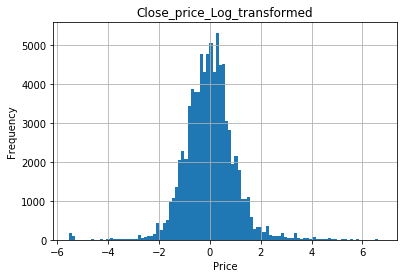

In [25]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.65))

all_data_log["Close"].hist(bins=100);
print("Skew: %f" % all_data_log["Close"].skew())
print("Kurt: %f" % all_data_log["Close"].kurt())
print("Mean: %f" % all_data_log["Close"].mean())
print("Std: %f" % all_data_log["Close"].std())
ax.set(title="Close_price_Log_transformed", ylabel="Frequency", xlabel="Price");

※ Confirm whether inverse transform works for Close price appropriately, or not

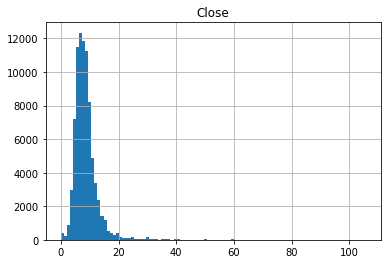

In [26]:
# inverse only for Close (Target)
y_log_inversed = inverse_trans_yeo_johnson(all_data_lagged2["Close"].values.reshape(-1,1), all_data_log["Close"].values.reshape(-1, 1))
y_log_inversed = pd.DataFrame(y_log_inversed)
y_log_inversed.columns = ["Close"]
y_log_inversed.hist(bins=100);

※If PowerTransformer does not work due to infinity value, the following process must be implemented.

In [27]:
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

In [28]:
# Searching infinity value
# a = all_data_lagged.replace([np.inf, -np.inf], np.nan)
# print(a.isnull().sum().head(150))

In [29]:
# all_data_lagged_2 = all_data_lagged_2.drop(["Total_Daylag_1", "Total_Daylag_1_HHlag_1"], axis=1)
# print(np.any(np.isnan(all_data_lagged).sum()))
# print(np.any(np.isfinite(all_data_lagged).sum()))

※ Inverse_transform(逆対数変換)についても調べる！！　予測後のClose priceを元の数値に戻す必要がある！！

# EDA (for all_data)

## Check the correlation of features with the target
    -->通年と直近１年とスパンを変えて見てみる

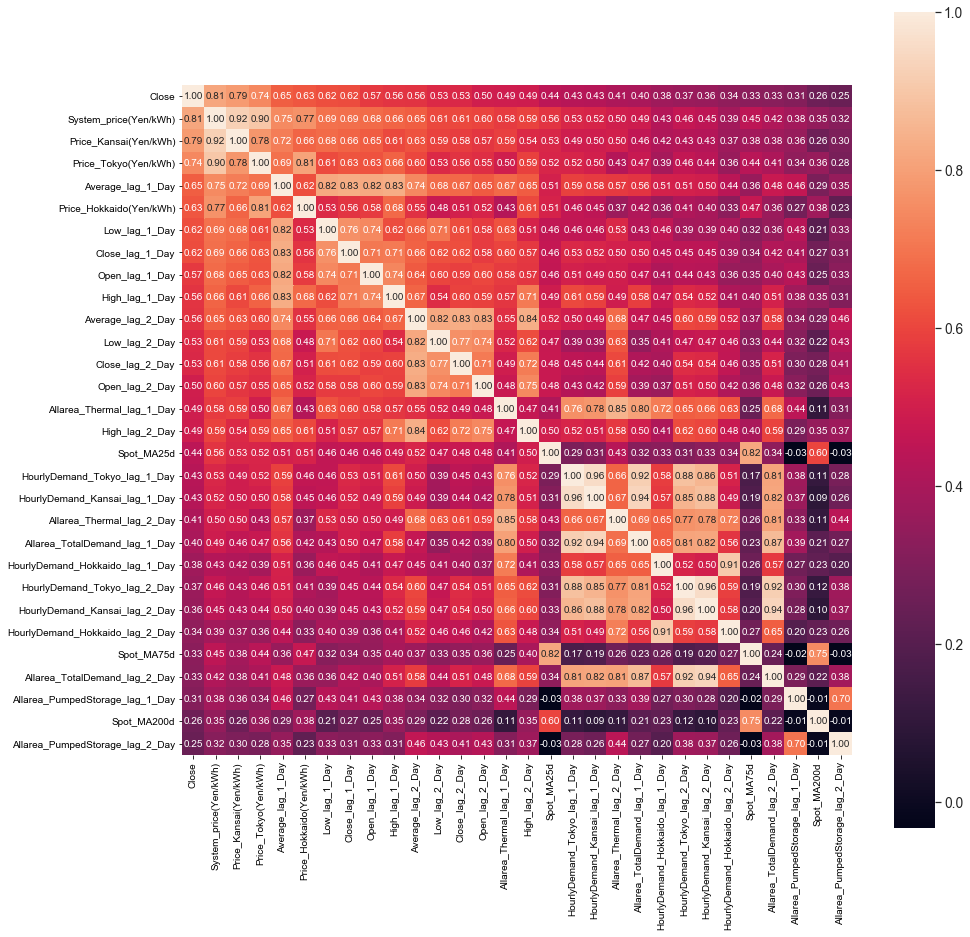

In [30]:
# correlation matrix
corrmat = all_data_log.corr()

# revenue correlation matrix
k = 30 # The number of variables on the heatmap
cols = corrmat.nlargest(k, 'Close')['Close'].index
cm = np.corrcoef(all_data_log[cols].values.T)
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [31]:
# # scatterplot
# sns.set()
# cols = ['Close', 'System_price(Yen/kWh)', 'Price_Tohoku(Yen/kWh)', 'Price_Tokyo(Yen/kWh)', 'Average_Daylag_2',
#         'Low_Daylag_2', 'Close_Daylag_2', 'Open_Daylag_2', 'High_Daylag_2', 'Low_Daylag_2_HHlag_1']
# sns.pairplot(all_data_log[cols], size=2.5)
# plt.show()

<メモ><p>
    - 外れ値は見られるが線形の関係が見られる
    - OpenとCloseの相関は見られないが、OpenとHighはなぜか相関が高い。（Openで高値がつきやすい？）
    - TokyoとTohokuは高い相関が見られる

外れ値はここで処理しておく --> ただし一概に外れ値を除去するべきとは限らない。要検討 <P>
全体のEDAで気になる点がでれば個別にEDA

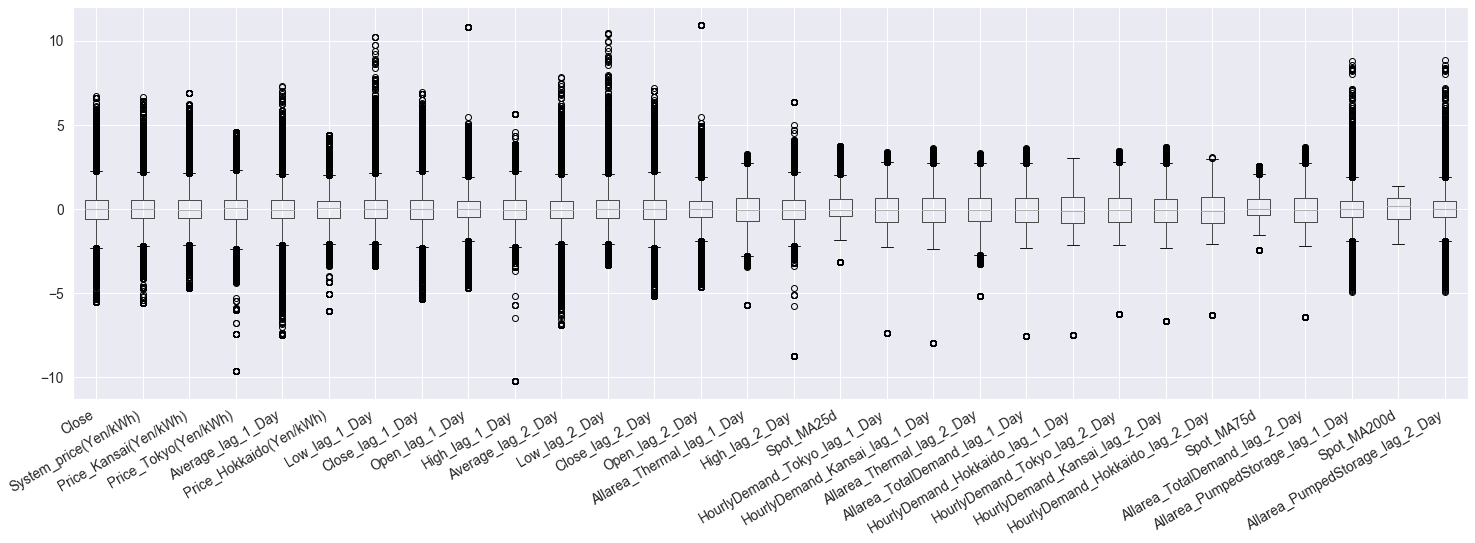

In [32]:
plt.figure(figsize = (25,8))
all_data_log[cols].boxplot()
plt.gcf().autofmt_xdate()

plt.show()

スケールも整っている

In [33]:
# Remove the ourliers 
# all_data = all_data[all_data.item_price<60000]

In [34]:
# Re-confirm the outliers with scatter plot
# var = "item_price"
# data = pd.concat([all_data['item_cnt_month'], all_data[var]], axis=1)
# data.plot.scatter(x=var, y='item_cnt_month', ylim=(0,100));

In [35]:
#整理後のtraining data
all_data_log.tail()

,Date,Time,HH,month,dayofweek,holiday,Planned_Min_flag,Planned_Max_flag,System_price(Yen/kWh),Price_Hokkaido(Yen/kWh),Price_Tokyo(Yen/kWh),Price_Kansai(Yen/kWh),BidExceed_diff,Spot_MA25d,Spot_MA75d,Spot_MA200d,Open_lag_1_Day,High_lag_1_Day,Low_lag_1_Day,Close_lag_1_Day,Average_lag_1_Day,Volume(MWh/h)_lag_1_Day,Volume(Tick count)_lag_1_Day,HourlyDemand_Hokkaido_lag_1_Day,HourlyDemand_Tokyo_lag_1_Day,HourlyDemand_Kansai_lag_1_Day,HourlyDemand_Okinawa_lag_1_Day,Wind_TOH_lag_1_Day,Geothermal_TOH_lag_1_Day,PumpedStorage_TOH_lag_1_Day,Interconnection_TOH_lag_1_Day,Geothermal_HOK_lag_1_Day,Wind_HOK_lag_1_Day,Interconnection_HOK_lag_1_Day,Wind_TKO_lag_1_Day,Interconnection_TKO_lag_1_Day,Wind_CHB_lag_1_Day,Interconnection_CHB_lag_1_Day,Wind_HKU_lag_1_Day,PumpedStorage_HKU_lag_1_Day,Interconnection_HKU_lag_1_Day,Nuclear_KAN_lag_1_Day,Wind_KAN_lag_1_Day,Interconnection_KAN_lag_1_Day,Thermal_CHG_lag_1_Day,Water_CHG_lag_1_Day,Wind_CHG_lag_1_Day,Interconnection_CHG_lag_1_Day,Nuclear_SHI_lag_1_Day,Wind_SHI_lag_1_Day,Interconnection_SHI_lag_1_Day,Nuclear_KYU_lag_1_Day,Geothermal_KYU_lag_1_Day,PV_KYU_lag_1_Day,PVCurtailment_KYU_lag_1_Day,Wind_KYU_lag_1_Day,WindCurtailment_KYU_lag_1_Day,Interconnection_KYU_lag_1_Day,Thermal_OKI_lag_1_Day,Biomass_OKI_lag_1_Day,Wind_OKI_lag_1_Day,Allarea_TotalDemand_lag_1_Day,Allarea_Water_lag_1_Day,Allarea_Thermal_lag_1_Day,Allarea_Geothermal_lag_1_Day,Allarea_Biomass_lag_1_Day,Allarea_PumpedStorage_lag_1_Day,Allarea_Interconnection_lag_1_Day,Water_Ratio_lag_1_Day,Thermal_Ratio_lag_1_Day,Geothermal_Ratio_lag_1_Day,VWAP_lag_1_Day,Open_lag_2_Day,High_lag_2_Day,Low_lag_2_Day,Close_lag_2_Day,Average_lag_2_Day,Volume(MWh/h)_lag_2_Day,Volume(Tick count)_lag_2_Day,HourlyDemand_Hokkaido_lag_2_Day,HourlyDemand_Tokyo_lag_2_Day,HourlyDemand_Kansai_lag_2_Day,HourlyDemand_Okinawa_lag_2_Day,Wind_TOH_lag_2_Day,Geothermal_TOH_lag_2_Day,PumpedStorage_TOH_lag_2_Day,Interconnection_TOH_lag_2_Day,Geothermal_HOK_lag_2_Day,Wind_HOK_lag_2_Day,Interconnection_HOK_lag_2_Day,Wind_TKO_lag_2_Day,Interconnection_TKO_lag_2_Day,Wind_CHB_lag_2_Day,Interconnection_CHB_lag_2_Day,Wind_HKU_lag_2_Day,PumpedStorage_HKU_lag_2_Day,Interconnection_HKU_lag_2_Day,Nuclear_KAN_lag_2_Day,Wind_KAN_lag_2_Day,Interconnection_KAN_lag_2_Day,Thermal_CHG_lag_2_Day,Water_CHG_lag_2_Day,Wind_CHG_lag_2_Day,Interconnection_CHG_lag_2_Day,Nuclear_SHI_lag_2_Day,Wind_SHI_lag_2_Day,Interconnection_SHI_lag_2_Day,Nuclear_KYU_lag_2_Day,Geothermal_KYU_lag_2_Day,PV_KYU_lag_2_Day,PVCurtailment_KYU_lag_2_Day,Wind_KYU_lag_2_Day,WindCurtailment_KYU_lag_2_Day,Interconnection_KYU_lag_2_Day,Thermal_OKI_lag_2_Day,Biomass_OKI_lag_2_Day,Wind_OKI_lag_2_Day,Allarea_TotalDemand_lag_2_Day,Allarea_Water_lag_2_Day,Allarea_Thermal_lag_2_Day,Allarea_Geothermal_lag_2_Day,Allarea_Biomass_lag_2_Day,Allarea_PumpedStorage_lag_2_Day,Allarea_Interconnection_lag_2_Day,Water_Ratio_lag_2_Day,Thermal_Ratio_lag_2_Day,Geothermal_Ratio_lag_2_Day,VWAP_lag_2_Day,Close
83232,2020-12-31,21:30:00,44,12,3,0,0.0,0.0,4.063279,2.662748,3.253262,4.812611,-0.504388,3.603386,0.243553,-0.567171,3.808611,3.019716,5.161585,3.367296,4.171711,0.964374,1.904803,1.239179,0.181169,0.047164,-0.354732,1.955140,2.267526,0.002207,-1.787592,0.070790,0.644805,-0.619248,2.003949,1.182478,1.092908,0.232592,1.830251,-0.078424,-0.357720,-1.584485,0.862107,0.227222,0.929178,0.749392,1.399785,-0.079328,-0.963722,0.855396,1.163172,0.647428,3.038208,-1.044648,-0.208739,1.900143,-0.090149,0.355000,-0.210331,1.158431,1.641782,0.446555,-1.054152,1.051937,3.088101,1.241828,1.094027,-1.521139,-1.069669,1.108956,-0.298313,-1.039528,2.929164,2.280778,2.468040,1.530581,3.037431,1.596300,1.874723,0.959799,-0.099750,-0.477586,-0.483745,0.794554,2.256819,0.002207,-1.669710,-0.079850,0.067846,-1.090294,1.173640,1.828739,-1.155730,-0.590297,1.820989,-0.078296,-0.915936,-1.584485,0.862698,0.432705,0.845091,0.506801,0.559975,0.118667,-0.963722,1.547765,0.955635,0.614949,2.772968,-1.044186,-0.208739,0.798499,-0.090149,-0.301519,-0.297990,1.072444,-1.465058,-0

## 各特徴量の再調整

外れ値を削除 or 残す
EDAの結果を見て不要な特徴量は削除 (特徴量間の相関が高いもの、目的関数との相関がないものを除外)

- 特徴量選択: https://qiita.com/shimopino/items/5fee7504c7acf044a521

# Training Models with "all_data"

機械学習アルゴまとめ: https://qiita.com/tomomoto/items/b3fd1ec7f9b68ab6dfe2

ここですべきことはクロスバリデーションでのモデル構築 --> 今回はwalk-forward validationを採用

TimeSeries validation from scikit-learn
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

参照(ブログ)<p>
- https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
- https://aizine.ai/cross-validation0910/#toc12
- 一番整理されている: https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95/

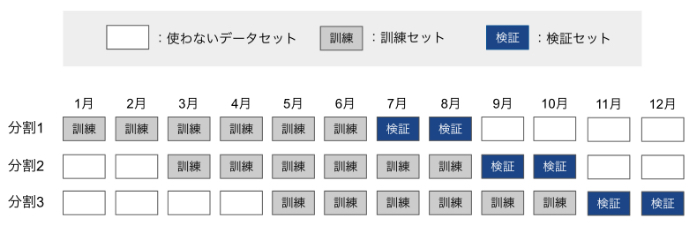

Split all_data set based on time-base

## Preparation

In [36]:
X = all_data_log.drop(['Close', 'Date', 'Time'], axis=1)
y = all_data_log.Closey = all_data_log.Close

Split all_data into train and valid for validation

In [37]:
# Rolling/Walk forward validation (Timeseries validation with the parameter of "max_train_size")
from sklearn.model_selection import TimeSeriesSplit

n_splits=10
train_ratio=8
test_ratio=2
max_train_size = 35040
# max_train_size=int(round((len(X)*train_ratio)/(train_ratio+test_ratio*n_splits), 0))
test_size=int(round((len(X)*test_ratio)/(train_ratio+test_ratio*n_splits), 0))

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size
                       , max_train_size=max_train_size
                      )
Min_valid_index = len(X) - (n_splits * test_size)

print(tscv)
print('Minimum of valid_index: %.0f' % Min_valid_index)

# Confirming the split logic
for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    print("TRAIN:", train_index, "Valid:", valid_index)

TimeSeriesSplit(gap=0, max_train_size=35040, n_splits=10, test_size=5946)
Minimum of valid_index: 23777
TRAIN: [    0     1     2 ... 23774 23775 23776] Valid: [23777 23778 23779 ... 29720 29721 29722]
TRAIN: [    0     1     2 ... 29720 29721 29722] Valid: [29723 29724 29725 ... 35666 35667 35668]
TRAIN: [  629   630   631 ... 35666 35667 35668] Valid: [35669 35670 35671 ... 41612 41613 41614]
TRAIN: [ 6575  6576  6577 ... 41612 41613 41614] Valid: [41615 41616 41617 ... 47558 47559 47560]
TRAIN: [12521 12522 12523 ... 47558 47559 47560] Valid: [47561 47562 47563 ... 53504 53505 53506]
TRAIN: [18467 18468 18469 ... 53504 53505 53506] Valid: [53507 53508 53509 ... 59450 59451 59452]
TRAIN: [24413 24414 24415 ... 59450 59451 59452] Valid: [59453 59454 59455 ... 65396 65397 65398]
TRAIN: [30359 30360 30361 ... 65396 65397 65398] Valid: [65399 65400 65401 ... 71342 71343 71344]
TRAIN: [36305 36306 36307 ... 71342 71343 71344] Valid: [71345 71346 71347 ... 77288 77289 77290]
TRAIN: [42251 

Make the tables for graph visualisation and for evaluation results

In [38]:
# DataTable for graph_log
graph_data_log = all_data_log[["Date", "Time", "Close"]]
graph_data_log["DateTime"] = pd.to_datetime(graph_data_log["Date"].astype(str) + " " + graph_data_log["Time"].astype(str))
prediction_point = graph_data_log["DateTime"][graph_data_log.index==Min_valid_index].iat[-1]
graph_data_log = graph_data_log.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation results_log
Eval_table_log = pd.DataFrame()
Eval_table_log["EvalFunc"] = pd.Series(["RMSE_log", "MAE_log"])
Eval_table_log

Prediction_point: 2017-08-09 08:30:00


,EvalFunc
0,RMSE_log
1,MAE_log


In [39]:
# DataTable for graph_original
graph_data_original = all_data_lagged[["Date", "Time", "Close"]]
graph_data_original["DateTime"] = pd.to_datetime(graph_data_original["Date"].astype(str) + " " + graph_data_original["Time"].astype(str))
prediction_point = graph_data_original["DateTime"][graph_data_original.index==Min_valid_index].iat[-1]
graph_data_original = graph_data_original.drop(["Date", "Time"], axis=1)
print("Prediction_point: {}".format(prediction_point))

# DataTable for Evaluation functions_original
Eval_table_original = pd.DataFrame()
Eval_table_original["EvalFunc"] = pd.Series(["RMSE_Yen/kWh", "MAE_Yen/kWh"])
Eval_table_original

Prediction_point: 2017-08-09 08:30:00


,EvalFunc
0,RMSE_Yen/kWh
1,MAE_Yen/kWh


## Linear model

### Linear regression

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
import itertools

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Line = []

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLine = LinearRegression().fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLine.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Line.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLine.score(X_train, y_train))     
    valid_accuracy.append(modelLine.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Line = list(itertools.chain.from_iterable(prediction_Line))
# Prediction with train data
y_pred_train = list(modelLine.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Linear"] = pd.Series(y_pred_train + prediction_Line)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Linear"] = pd.Series([np.mean(rmse), np.mean(mae)])
rmse_10fold_Linear = pd.Series(rmse)
mae_10fold_Linear = pd.Series(mae)

Training_accuracy: 0.6530211950786735
Valid_accuracy: 0.5485440237321241
RMSE: 0.6091538155445516
MAE: 0.43185189468052537


In [41]:
rmse

[0.5640679152533372,
 0.5232173934452167,
 0.5609294229440482,
 0.48309976929546666,
 0.6336523073200692,
 0.5632113815590546,
 0.585848080287952,
 0.6897139050122754,
 0.7591079878167745,
 0.7286899925113219]

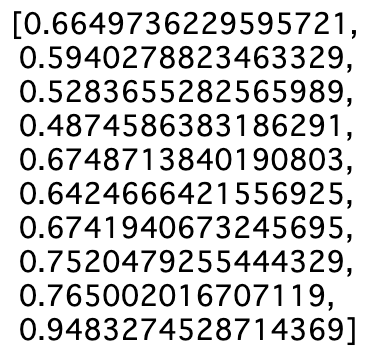

In [42]:
mae

[0.4015228490465306,
 0.3826746339179186,
 0.4144982839551759,
 0.35917779145351375,
 0.46374851265045025,
 0.3937778840493092,
 0.40417851986593556,
 0.4713378942683513,
 0.5172112144022084,
 0.5103913631958603]

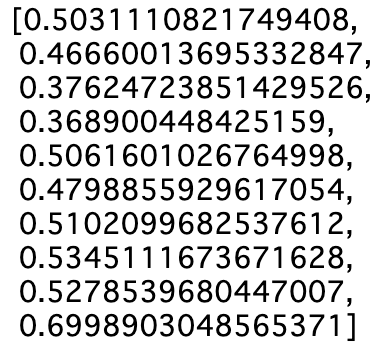

### Ridge

In [43]:
# Searching the optimal alpha
for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # For the test of alpha
    for alpha in [0.1, 1, 3, 7, 10]: # alphaで特に結果の違いなし (0.1, 1, 3, 7, 10)
        modelRidge = Ridge(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelRidge.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelRidge.score(X_valid, y_valid)))
        y_pred = modelRidge.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelRidge.coef_ != 0)))


 alpha=0.1
Train set score: 0.66
Test set score: 0.50
RMSE: 0.56
MAE: 0.40
Number of features used:124

 alpha=1
Train set score: 0.66
Test set score: 0.50
RMSE: 0.56
MAE: 0.40
Number of features used:124

 alpha=3
Train set score: 0.66
Test set score: 0.50
RMSE: 0.56
MAE: 0.40
Number of features used:124

 alpha=7
Train set score: 0.66
Test set score: 0.50
RMSE: 0.56
MAE: 0.40
Number of features used:124

 alpha=10
Train set score: 0.66
Test set score: 0.50
RMSE: 0.56
MAE: 0.40
Number of features used:124

 alpha=0.1
Train set score: 0.63
Test set score: 0.66
RMSE: 0.52
MAE: 0.38
Number of features used:122

 alpha=1
Train set score: 0.63
Test set score: 0.66
RMSE: 0.52
MAE: 0.38
Number of features used:122

 alpha=3
Train set score: 0.63
Test set score: 0.66
RMSE: 0.52
MAE: 0.38
Number of features used:122

 alpha=7
Train set score: 0.63
Test set score: 0.66
RMSE: 0.52
MAE: 0.38
Number of features used:122

 alpha=10
Train set score: 0.63
Test set score: 0.66
RMSE: 0.52
MAE: 0.38
Nu

10 is the optimal

In [44]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Ridge = []

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    #Fit train set to the model
    modelRidge = linear_model.Ridge(alpha=10).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelRidge.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Ridge.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelRidge.score(X_train, y_train))     
    valid_accuracy.append(modelRidge.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Ridge = list(itertools.chain.from_iterable(prediction_Ridge))
# Prediction with train data
y_pred_train = list(modelRidge.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Ridge"] = pd.Series(y_pred_train + prediction_Ridge)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Ridge"] = pd.Series([np.mean(rmse), np.mean(mae)])
rmse_10fold_Ridge = pd.Series(rmse)
mae_10fold_Ridge = pd.Series(mae)

Training_accuracy: 0.6529124358171928
Valid_accuracy: 0.5486716923447282
RMSE: 0.6094417599431041
MAE: 0.43216311466461244


In [45]:
rmse

[0.5632027706731648,
 0.5232857191333941,
 0.5597945521456082,
 0.48292106312912014,
 0.6315396644180312,
 0.5632463107276827,
 0.5858773755086575,
 0.6903147904048421,
 0.7593266484026627,
 0.7349087048878766]

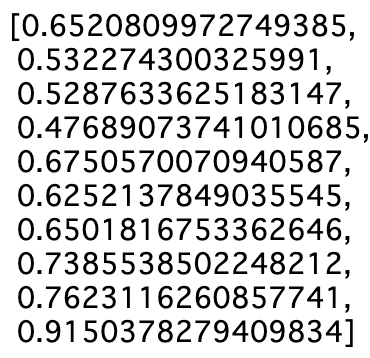

In [46]:
mae

[0.40038237858526915,
 0.3827603971522505,
 0.4133592634513488,
 0.3588937412732208,
 0.4616247404928264,
 0.3939602240839927,
 0.40405448850285525,
 0.472135482644694,
 0.5170364209685911,
 0.517424009491076]

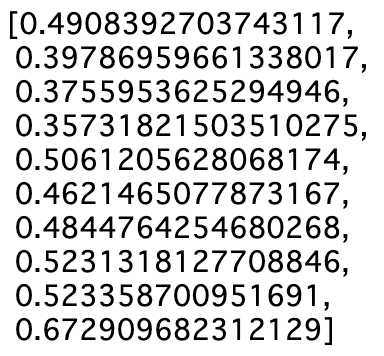

### Lasso

In [47]:
for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # For the test of alpha
    for alpha in [0.02, 0.5, 1]: #0.02 is the best (0.02, 0.5, 1)
        modelLasso = Lasso(alpha=alpha).fit(X_train, y_train)
        print("\n alpha={}".format(str(alpha)))
        print("Train set score: {:.2f}".format(modelLasso.score(X_train, y_train)))
        print("Test set score: {:.2f}".format(modelLasso.score(X_valid, y_valid)))
        y_pred = modelLasso.predict(X_valid)       
        print("RMSE: {:.2f}".format(sqrt(mean_squared_error(y_valid, y_pred))) )      
        print("MAE: {:.2f}".format(mean_absolute_error(y_valid, y_pred)))
        print("Number of features used:{}".format(np.sum(modelLasso.coef_ != 0)))


 alpha=0.02
Train set score: 0.64
Test set score: 0.51
RMSE: 0.56
MAE: 0.38
Number of features used:20

 alpha=0.5
Train set score: 0.06
Test set score: 0.04
RMSE: 0.78
MAE: 0.59
Number of features used:1

 alpha=1
Train set score: 0.06
Test set score: 0.04
RMSE: 0.78
MAE: 0.59
Number of features used:1

 alpha=0.02
Train set score: 0.61
Test set score: 0.63
RMSE: 0.55
MAE: 0.41
Number of features used:18

 alpha=0.5
Train set score: 0.06
Test set score: -0.54
RMSE: 1.12
MAE: 0.86
Number of features used:1

 alpha=1
Train set score: 0.05
Test set score: -0.54
RMSE: 1.12
MAE: 0.86
Number of features used:1

 alpha=0.02
Train set score: 0.66
Test set score: 0.62
RMSE: 0.53
MAE: 0.37
Number of features used:19

 alpha=0.5
Train set score: 0.07
Test set score: -0.00
RMSE: 0.87
MAE: 0.60
Number of features used:2

 alpha=1
Train set score: 0.04
Test set score: -0.01
RMSE: 0.87
MAE: 0.60
Number of features used:1

 alpha=0.02
Train set score: 0.68
Test set score: 0.50
RMSE: 0.47
MAE: 0.34
N

0.02 is the optimal

In [48]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Lasso = []

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    #Fit train set to the model (Chooose one model)
    modelLasso = linear_model.Lasso(alpha=0.02).fit(X_train, y_train)

    # Generate prediction results
    y_pred = modelLasso.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_Lasso.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelLasso.score(X_train, y_train))     
    valid_accuracy.append(modelLasso.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Lasso = list(itertools.chain.from_iterable(prediction_Lasso))
# Prediction with train data
y_pred_train = list(modelLasso.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_Lasso"] = pd.Series(y_pred_train + prediction_Lasso)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["Lasso"] = pd.Series([np.mean(rmse), np.mean(mae)])
rmse_10fold_Lasso = pd.Series(rmse)
mae_10fold_Lasso = pd.Series(mae)

Training_accuracy: 0.6369803287671999
Valid_accuracy: 0.5662194684340334
RMSE: 0.593531234345487
MAE: 0.4138918767574287


In [49]:
rmse

[0.5556672960889008,
 0.5463676513239569,
 0.5310514033457566,
 0.47423623227281525,
 0.6029666388101641,
 0.5661068031269183,
 0.5853284606355347,
 0.6877611457068189,
 0.764513340119112,
 0.6213133720248927]

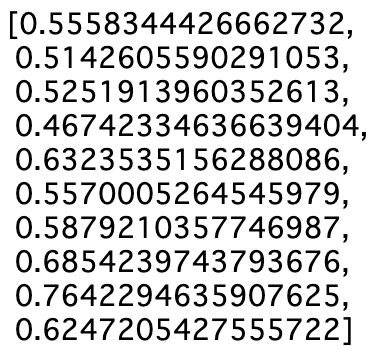

In [50]:
mae

[0.3843394545161727,
 0.40511154221866563,
 0.3729566005991857,
 0.34488966474032545,
 0.43409752598287876,
 0.40031563213598176,
 0.39797895831391256,
 0.4683279299807091,
 0.5205281241260755,
 0.4103733349603798]

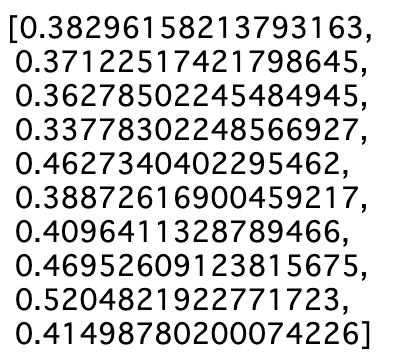

In [51]:
Eval_table_log.head()

,EvalFunc,Linear,Ridge,Lasso
0,RMSE_log,0.609154,0.609442,0.593531
1,MAE_log,0.431852,0.432163,0.413892


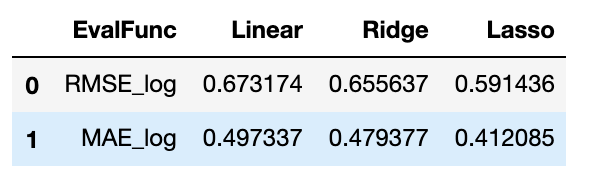

### Interpretation of the linear model
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

In [52]:
print("Intercept: {}".format(modelLine.intercept_))

feature_names = X_train.columns
coefs = pd.DataFrame(modelLasso.coef_, columns=['Coefficients'], index=feature_names
).sort_values('Coefficients', ascending=False)

# Absolute value of coefficients
coef_abs = coefs.abs()
print(coef_abs.head(10))

Intercept: -0.15397039169534932
                                 Coefficients
System_price(Yen/kWh)                0.496724
Price_Kansai(Yen/kWh)                0.156699
Price_Tokyo(Yen/kWh)                 0.058643
Low_lag_1_Day                        0.035843
Close_lag_1_Day                      0.028820
Price_Hokkaido(Yen/kWh)              0.026732
Allarea_Thermal_lag_1_Day            0.017801
Allarea_PumpedStorage_lag_1_Day      0.016171
Interconnection_HKU_lag_1_Day        0.016067
HourlyDemand_Hokkaido_lag_2_Day      0.007761


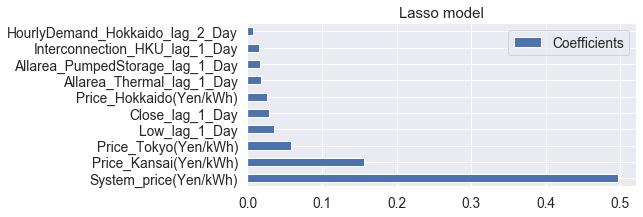

In [53]:
# Positive coeficients
coefs[:10].plot(kind='barh', figsize=(9, 3))
plt.title('Lasso model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

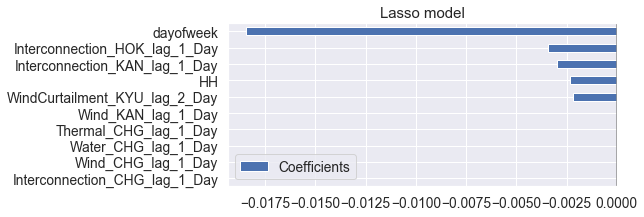

In [54]:
# Negative coeficients
end = len(coefs)
start = end - 10
coefs[start:end].plot(kind='barh', figsize=(9, 3))
plt.title('Lasso model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

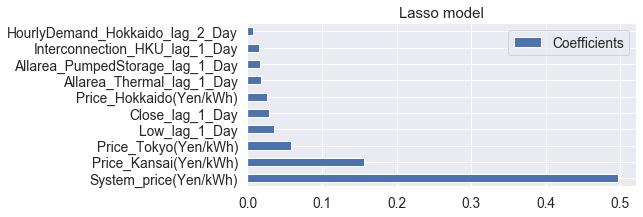

In [55]:
# Absolute coeficients
coef_abs[:10].plot(kind='barh', figsize=(9, 3))
plt.title('Lasso model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Non-linear model

## Linear Regression with PolynomialFeatures

In [56]:
X.shape

(83237, 126)

In [57]:
# Make polynominal features
from sklearn.preprocessing import PolynomialFeatures

dimension = 2
polynomial = PolynomialFeatures(degree=dimension)
Poly_X = polynomial.fit_transform(X)
Poly_X = pd.DataFrame(Poly_X)

In [58]:
Poly_X.shape

(83237, 8128)

特徴量選択で次数を十分減らした後場合のみ実行可能！！

In [59]:
# training_accuracy = []
# valid_accuracy = []
# rmse = []
# mae = []
# prediction_PolyLine = []
    
# for train_index, valid_index in tscv.split(X):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#     y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
#     #Fit train set to the model (Chooose one model)
#     modelPolyLine = LinearRegression().fit(X_train, y_train)
    
#     # Generate prediction results
#     y_pred = modelPolyLine.predict(X_valid)
#     true_values = y_valid.values
#     # Save prediction results
#     prediction_PolyLine.append(y_pred)
#     # Save evaluation results for each 10 validation and get mean
#     training_accuracy.append(modelPolyLine.score(X_train, y_train))     
#     valid_accuracy.append(modelPolyLine.score(X_valid, y_valid))     
#     rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
#     mae.append(mean_absolute_error(true_values, y_pred))

# # print("Training_accuracy: {}".format(training_accuracy))
# print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# # print("Valid_accuracy: {}".format(valid_accuracy))
# print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# # print("RMSE: {}".format(rmse))
# print("RMSE: {}".format(np.mean(rmse)))
# # print("MAE: {}".format(mae))
# print("MAE: {}".format(np.mean(mae)))

# # Convert prediction results with valid data from 2D list to 1D list
# prediction_PolyLine = list(itertools.chain.from_iterable(prediction_PolyLine))
# # Prediction with train data
# y_pred_train = list(modelPolyLine.predict(X_train)[:Min_valid_index])
# # Store the prediction into the "graph data" table
# #graph_data_log = graph_data_log.reset_index()
# graph_data_log["Close_pred_PolyLinear"] = pd.Series(y_pred_train + prediction_PolyLine)
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["PolyLinear"] = pd.Series([np.mean(rmse), np.mean(mae)])

## XGBoost

In [60]:
from xgboost import XGBRegressor

training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_XGB = []

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    #Fit train set to the model
    modelXGB = XGBRegressor().fit(X_train, y_train)   
    # Generate prediction results
    y_pred = modelXGB.predict(X_valid)
    true_values = y_valid.values
    # Save prediction results
    prediction_XGB.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    training_accuracy.append(modelXGB.score(X_train, y_train))     
    valid_accuracy.append(modelXGB.score(X_valid, y_valid))     
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("Training_accuracy: {}".format(training_accuracy))
print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# print("Valid_accuracy: {}".format(valid_accuracy))
print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_XGB = list(itertools.chain.from_iterable(prediction_XGB))
# Prediction with train data
y_pred_train = list(modelXGB.predict(X_train)[:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_log["Close_pred_XGB"] = pd.Series(y_pred_train + prediction_XGB)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["XGB"] = pd.Series([np.mean(rmse), np.mean(mae)])

Training_accuracy: 0.8490080024450928
Valid_accuracy: 0.37505655712823366
RMSE: 0.7148425960989894
MAE: 0.5241062338509194


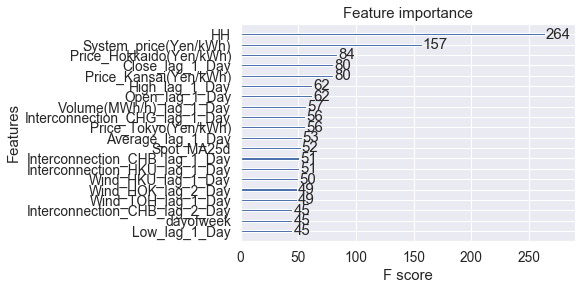

<Figure size 1000x500 with 0 Axes>

In [61]:
# Feature importance of the last train set
from xgboost import plot_importance

# plot feature importance
plot_importance(modelXGB, max_num_features = 20)
plt.figure(figsize=(10, 5),dpi=100)
plt.show()

In [62]:
Eval_table_log.head()

,EvalFunc,Linear,Ridge,Lasso,XGB
0,RMSE_log,0.609154,0.609442,0.593531,0.714843
1,MAE_log,0.431852,0.432163,0.413892,0.524106


## RandomForest ※時間がかかるのでskip

In [63]:
from sklearn.ensemble import RandomForestRegressor

# training_accuracy = []
# valid_accuracy = []
# rmse = []
# mae = []
# prediction_RF = []

# for train_index, valid_index in zip(Rolling_forward_split_train, Rolling_forward_split_valid):
#     # Divide the train/valid set  into 10 folds and pick up it.
#     X_train, X_valid = X.iloc[:train_index], X.iloc[train_index: valid_index]
#     y_train, y_valid = y.iloc[:train_index], y.iloc[train_index: valid_index]

#     #Fit train set to the model
#     modelRF = RandomForestRegressor(n_jobs = -1).fit(X_train, y_train) 
#     # Generate prediction results
#     y_pred = modelRF.predict(X_valid)
#     true_values = y_valid.values
#     # Save prediction results
#     prediction_RF.append(y_pred)
#     # Save evaluation results for each 10 validation and get mean
#     training_accuracy.append(modelRF.score(X_train, y_train))     
#     valid_accuracy.append(modelRF.score(X_valid, y_valid))     
#     rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
#     mae.append(mean_absolute_error(true_values, y_pred))

# # print("Training_accuracy: {}".format(training_accuracy))
# print("Training_accuracy: {}".format(np.mean(training_accuracy)))
# # print("Valid_accuracy: {}".format(valid_accuracy))
# print("Valid_accuracy: {}".format(np.mean(valid_accuracy)))

# # print("RMSE: {}".format(rmse))
# print("RMSE: {}".format(np.mean(rmse)))
# # print("MAE: {}".format(mae))
# print("MAE: {}".format(np.mean(mae)))

# # Convert prediction results with valid data from 2D list to 1D list
# prediction_RF = list(itertools.chain.from_iterable(prediction_RF))
# # Prediction with train data
# y_pred_train = list(modelRF.predict(X_train)[:Min_valid_index])
# # Store the prediction into the "graph data" table
# graph_data_log["Close_pred_RF"] = pd.Series(y_pred_train + prediction_RF)
# # Store the result of evaluation into the "Eval_table"
# Eval_table_log["RF"] = pd.Series([np.mean(rmse), np.mean(mae)])

In [64]:
# Feature importance of the last train set
# # plot feature importance
# df_feature_importance = pd.DataFrame(modelRF.feature_importances_, index=feature_list, columns=['feature importance']).sort_values('feature importance', ascending=True)
# #df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in reg.estimators_], columns=boston.feature_names)
# df_feature_importance_top10 = df_feature_importance.tail(10)
# df_feature_importance_top10.plot(kind='barh');

# ARIMA model (基本的にパラメータチューニングはしない！)

複数の説明変数を
 - ARIMAに適用するならARIMAXモデル (ARIMAに直接適用可能)
 - SARIMAに適用するならSARIMAXモデル
    
(Reference)
VAR(比較的簡単): https://logics-of-blue.com/var%E3%83%A2%E3%83%87%E3%83%AB/
VAR: https://analytics-note.xyz/time-series/statsmodels-var-fit/
VAR(理論と実装): https://qiita.com/innovation1005/items/b5333a939c0341b46ba9
ARIMAX(数式のみ): https://qiita.com/shu-yusa/items/1c6148e4e6e523d644ae

In [65]:
# Top 5 coefficient from Linear model
coef_abs = coefs.abs()
coef_abs_list = list(coef_abs[:5].index)
# Pick up  Date, Time , Close and cols that have high importance on the linear model
arima_cols = ["Date", "Time", "Close"]
arima_cols = arima_cols + coef_abs_list
arima_cols

['Date',
 'Time',
 'Close',
 'System_price(Yen/kWh)',
 'Price_Kansai(Yen/kWh)',
 'Price_Tokyo(Yen/kWh)',
 'Low_lag_1_Day',
 'Close_lag_1_Day']

In [66]:
# Data for statistical modeling
all_data_stats = all_data_log.copy()
all_data_stats = all_data_stats[arima_cols]
all_data_stats["DateTime"] = pd.to_datetime(all_data_stats["Date"].astype(str) + " " + all_data_stats["Time"].astype(str))
all_data_stats = all_data_stats.drop(["Date", "Time"], axis=1)
X_stats = all_data_stats.drop(['Close', "DateTime"], axis=1)
X_stats =  np.array(X_stats)
y_stats = all_data_stats[["Close"]]
y_stats =  np.array(y_stats)

In [67]:
# ADF test for logarithmic price
ctt = sm.tsa.adfuller(y_stats, regression="ctt")
round(ctt[1], 4)

0.0

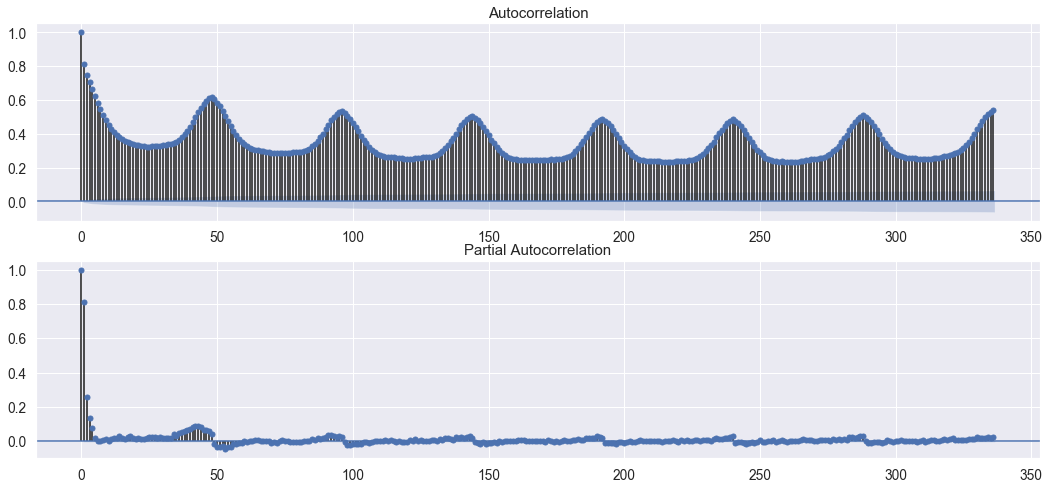

In [68]:
# Autocorrelation
fig = plt.figure(figsize=(18,8))
# Autocorrelation (1lag=30min --> 336 lags=1week)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_stats, lags=336, ax=ax1)

# Partial Autocorrelation
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_stats, lags=336, ax=ax2)

### ARIMAX model

In [69]:
from statsmodels.tsa.arima.model import ARIMA

modelARIMA = ARIMA(y_stats, exog=X_stats).fit()

# Summary
print(modelARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                83237
Model:                          ARIMA   Log Likelihood              -70584.770
Date:                Wed, 31 Mar 2021   AIC                         141183.540
Time:                        00:48:57   BIC                         141248.846
Sample:                             0   HQIC                        141203.523
                              - 83237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.899e-06      0.002     -0.002      0.998      -0.004       0.004
x1             0.3726      0.004     90.845      0.000       0.365       0.381
x2             0.2664      0.003     85.761      0.0

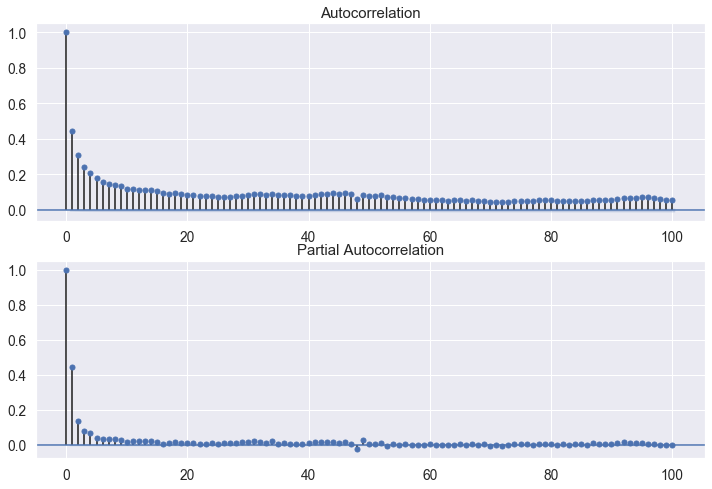

In [70]:
# Check the residual
resid = modelARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=100, ax=ax2)

残差に周期性やパターンが残っているということは、モデルにそれらを組み込めていないということ

-->説明変数を組み込むと残差がかなり消える

In [71]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_ARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    all_train, all_valid = all_data_stats.iloc[train_index], all_data_stats.iloc[valid_index]
    all_train, all_valid = all_train.set_index("DateTime"), all_valid.set_index("DateTime")
    # Pandas --> ndarray
    X_train = all_train.drop(['Close'], axis=1)
    X_train =  np.array(X_train)
    y_train = all_train[["Close"]]
    y_train =  np.array(y_train)
    X_valid = all_valid.drop(['Close'], axis=1)
    X_valid =  np.array(X_valid)
    y_valid = all_valid[["Close"]]
    y_valid =  np.array(y_valid) 

    #Fit train set to the model
    modelARIMA = ARIMA(y_train, exog=X_train
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelARIMA.forecast(steps=test_size, exog=X_valid) # test_size is set on "Preparation"
    true_values = y_valid
    # Save prediction results
    prediction_ARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_ARIMA = list(itertools.chain.from_iterable(prediction_ARIMA))
# Prediction with train data
y_pred_train = list(modelARIMA.predict())
y_pred_train = y_pred_train[:Min_valid_index]
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_ARIMA"] = pd.Series(y_pred_train + prediction_ARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["ARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 0.5933378041895077
MAE: 0.4128827100478508


# SARIMAX model

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelSARIMA = SARIMAX(y_stats, exog=X_stats).fit()
print(modelSARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                83237
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -61359.975
Date:                Wed, 31 Mar 2021   AIC                         122733.951
Time:                        00:55:43   BIC                         122799.257
Sample:                             0   HQIC                        122753.934
                              - 83237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3798      0.005     77.512      0.000       0.370       0.389
x2             0.2558      0.004     65.037      0.000       0.248       0.263
x3             0.1343      0.003     39.073      0.0

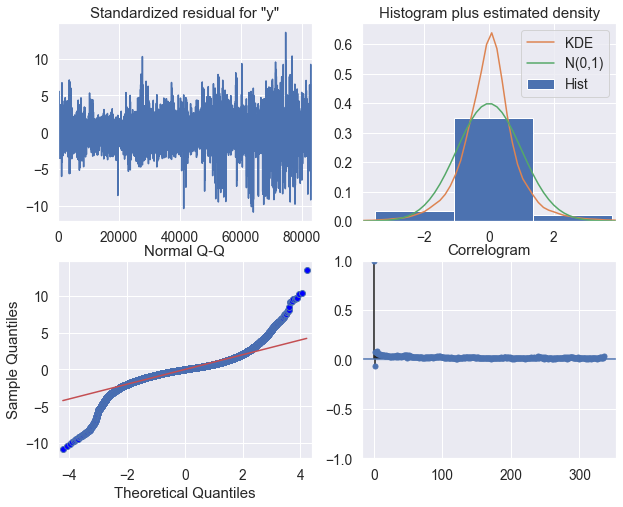

In [73]:
# Check residual (If periodicity can be seen, SARIMA model would be better)
# Plot/confirm residual (White noise)
modelSARIMA.plot_diagnostics(lags=336, figsize=[10, 8]);

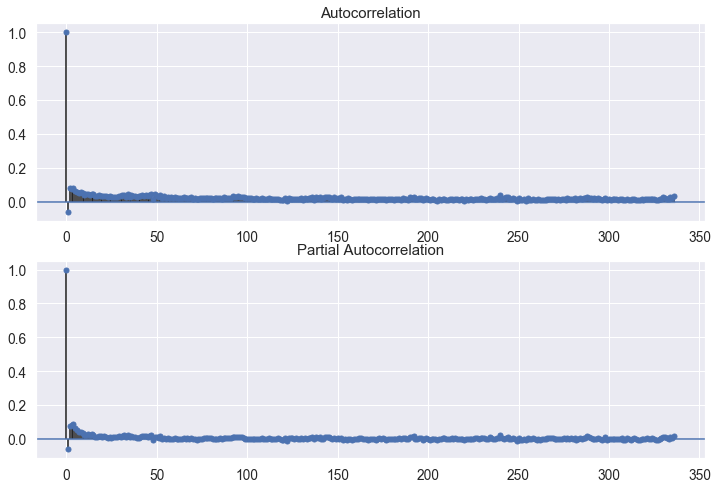

In [74]:
# Plot pertial Autocorrelation
resid = modelSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=336, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=336, ax=ax2)

SARIMAモデルのほうが季節性をカバーできているみたい --> SARIMAXですすめる

In [75]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_SARIMA = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)

for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    all_train, all_valid = all_data_stats.iloc[train_index], all_data_stats.iloc[valid_index]
    all_train, all_valid = all_train.set_index("DateTime"), all_valid.set_index("DateTime")
    # Pandas --> ndarray
    X_train = all_train.drop(['Close'], axis=1)
    X_train =  np.array(X_train)
    y_train = all_train[["Close"]]
    y_train =  np.array(y_train)
    X_valid = all_valid.drop(['Close'], axis=1)
    X_valid =  np.array(X_valid)
    y_valid = all_valid[["Close"]]
    y_valid =  np.array(y_valid) 
 
    #Fit train set to the model
    modelSARIMA = SARIMAX(y_train, 
#                        order=(2, 0, 3),
                      ).fit() #上記セルのパラメータを参照
    # Generate prediction results
    y_pred = modelSARIMA.forecast(steps=test_size, exog=X_valid) # test_size is set on "Preparation"
    true_values = y_valid
    # Save prediction results
    prediction_SARIMA.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_SARIMA = list(itertools.chain.from_iterable(prediction_SARIMA))
# Prediction with train data
y_pred_train = list(modelSARIMA.predict())
y_pred_train = y_pred_train[:Min_valid_index]
# Store the prediction into the "graph data" table
graph_data_log = graph_data_log.reset_index()
graph_data_log["Close_pred_SARIMA"] = pd.Series(y_pred_train + prediction_SARIMA)
# Store the result of evaluation into the "Eval_table"
Eval_table_log["SARIMA"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 1.0435953626841301
MAE: 0.7790876079134474


## Prophet
Document of Prophet from Facebook
https://peerj.com/preprints/3190/

数式の理解
https://devblog.thebase.in/entry/2019/12/20/110000_1

日本語の解説 (公式ではないが結構細かい)
https://mikiokubo.github.io/analytics/15forecast.html

外部変数追加のチュートリアル
https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [114]:
# # Pick up  Date, Time , Close and cols that have high importance on the linear model
X_cols =  coef_abs_list

In [115]:
all_data_prop = all_data_lagged[X_cols]
all_data_prop["Date"], all_data_prop["Time"], all_data_prop["Close"] = all_data_lagged["Date"], all_data_lagged["Time"], all_data_lagged["Close"]
all_data_prop["DateTime"] = pd.to_datetime(all_data_prop["Date"].astype(str) + " " + all_data_prop["Time"].astype(str))
all_data_prop = all_data_prop.drop(["Date", "Time"], axis=1)
all_data_prop.tail()

,System_price(Yen/kWh),Price_Kansai(Yen/kWh),Price_Tokyo(Yen/kWh),Low_lag_1_Day,Close_lag_1_Day,Close,DateTime
83232,35.0,50.0,35.0,30.00,30.00,70.00,2020-12-31 21:30:00
83233,45.0,50.0,40.0,30.00,30.00,45.48,2020-12-31 22:00:00
83234,40.0,40.0,40.0,29.00,29.00,41.33,2020-12-31 22:30:00
83235,35.0,35.0,35.0,28.92,34.21,36.66,2020-12-31 23:00:00
83236,25.0,25.0,25.0,17.76,26.79,26.46,2020-12-31 23:30:00


In [116]:
# Set ds and y for the model
all_data_prop = all_data_prop.rename(columns={'DateTime': 'ds', 'Close': 'y'})

In [117]:
# Divide dataset into train/valid set
all_data_prop_train = all_data_prop.iloc[all_data_prop.index[:len(X)-test_size]]
all_data_prop_valid = all_data_prop.iloc[all_data_prop.index[len(X)-test_size:]]

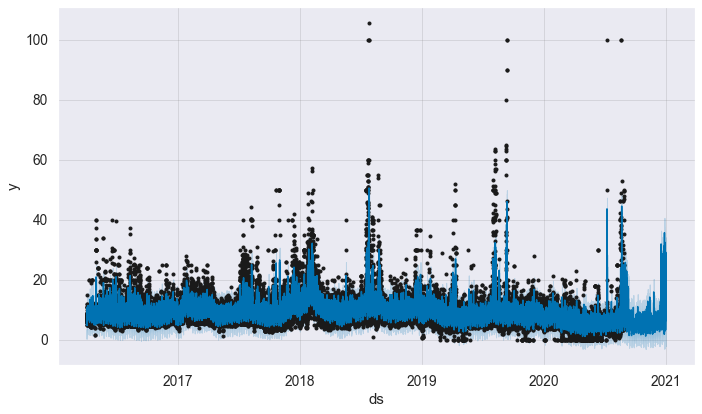

In [118]:
from fbprophet import Prophet
modelProp = Prophet()
# set exog for train data
for x in X_cols:
    modelProp = Prophet().add_regressor(x)

# fit train data
modelProp = modelProp.fit(all_data_prop_train)
# Make prediction datatable
future = modelProp.make_future_dataframe(periods=len(all_data_prop_valid), freq='30min')

# set exog for valid data
for x in X_cols:
    future[x] = all_data_prop[x]

# Plot
forecast = modelProp.predict(future)
modelProp.plot(forecast);

In [127]:
training_accuracy = []
valid_accuracy = []
rmse = []
mae = []
prediction_Prophet = []

# Set the parameter for .predict() which is for in-sample prediciton
train_end =  prediction_point.to_pydatetime() - datetime.timedelta(minutes=30)
    
for train_index, valid_index in tscv.split(X):
    # Divide the train/valid set  into 10 folds and pick up it.
    train_prop, valid_prop = all_data_prop.iloc[train_index], all_data_prop.iloc[valid_index]

    # Add exog for train data
    for x in X_cols:
        modelProphet = Prophet(yearly_seasonality=True).add_regressor(x)
    
    # fit train data
    modelProphet = modelProphet.fit(train_prop) 
    # Make prediction datatable (Need to adjust the parameter of period to match the number of rows)
    future = modelProphet.make_future_dataframe(periods=len(valid_prop), freq='30min')
    # Adjust index (This is needed only for walkforwardCV)
    future.index = future.index + train_index.min()
    # Add exog for valid data
    for x in X_cols:
        # Add exog for valid data
        future[x] = all_data_prop[x]
    
    # Generate prediction results
#     future = future.fillna(0, inplace=True)
    forecast = modelProphet.predict(future)
     # Adjust index (This is needed only for walkforwardCV)
    forecast.index = forecast.index + train_index.min()
    y_pred = forecast["yhat"][valid_index]
    true_values = valid_prop["y"]
    # Save prediction results
    prediction_Prophet.append(y_pred)
    # Save evaluation results for each 10 validation and get mean
    rmse.append(sqrt(mean_squared_error(true_values, y_pred)))       
    mae.append(mean_absolute_error(true_values, y_pred))

# print("RMSE: {}".format(rmse))
print("RMSE: {}".format(np.mean(rmse)))
# print("MAE: {}".format(mae))
print("MAE: {}".format(np.mean(mae)))

# Convert prediction results with valid data from 2D list to 1D list
prediction_Prophet = list(itertools.chain.from_iterable(prediction_Prophet))
# Prediction with train data
y_pred_train = list(forecast["yhat"][:Min_valid_index])
# Store the prediction into the "graph data" table
graph_data_original["Close_pred_Prophet"] = pd.Series(y_pred_train + prediction_Prophet)
# Store the result of evaluation into the "Eval_table"
Eval_table_original["Prophet"] = pd.Series([np.mean(rmse), np.mean(mae)])

RMSE: 4.383498237358509
MAE: 2.9615817634958157


# Visualisation of the model performance 

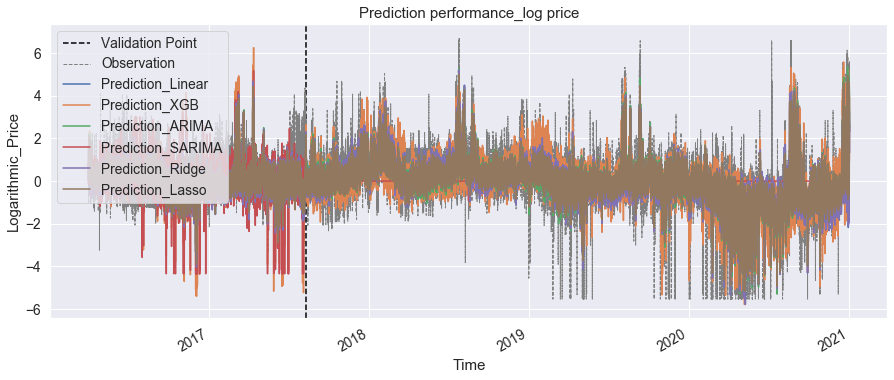

In [82]:
#対数化されたターゲットと予測値の比較

Models = [
    "Linear",
#    ,"PolyLinear",
        "XGB", "ARIMA", "SARIMA", "Ridge", "Lasso"
         ]

fig, ax = plt.subplots(1, figsize=(15, 6))
plt.title('Prediction performance_log price')

# Set index
graph_data_log = graph_data_log.set_index("DateTime")
start = "2016-04-01 00:00:00"
end = "2020-12-31 23:30:00"

# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Validation Point", linestyle="dashed", color="black")
# Add text for the vertical line
# plt.text(prediction_point.to_pydatetime(), -2, 'Prediction Point',rotation=0)

# Plot Close 
graph_data_log.Close[graph_data_log.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

for model in Models:
    graph_data_log["Close_pred_" + model][graph_data_log.index > start].plot(ax=ax, label="Prediction_" + model)

# x-axis
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Logarithmic_Price")
plt.legend(loc="upper left");

KeyError: 'Close_pred_Prophet'

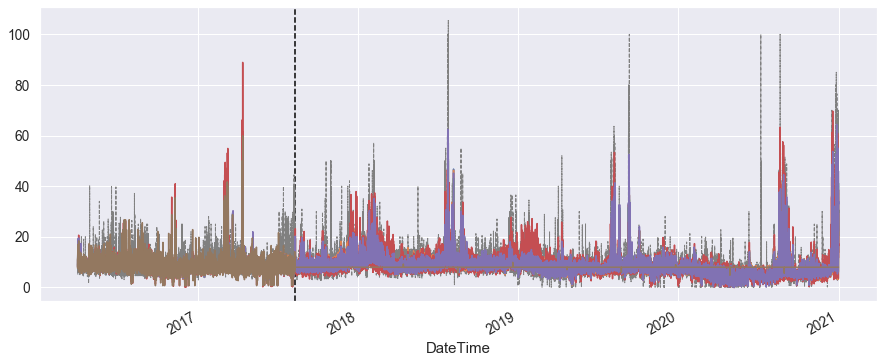

In [87]:
graph_data_original = graph_data_original.reset_index()

Models = [
            "Linear", "Ridge", "Lasso",
#           , "PolyLinear",
          "XGB", "ARIMA", "SARIMA"
]

for model in Models:
    # inverse for Prediction
    y_pred_original = inverse_trans_yeo_johnson(all_data_lagged["Close"].values.reshape(-1,1), graph_data_log["Close_pred_" + model].values.reshape(-1, 1))
    y_pred_original =  pd.DataFrame(y_pred_original)
    # Add the data on "graph_data"
    graph_data_original["Close_pred_" + model] = y_pred_original
    
    # Validation setに対してYen/kWhでの評価
    rmse = sqrt(mean_squared_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:]))
    mae = mean_absolute_error(graph_data_original.Close[Min_valid_index:], graph_data_original["Close_pred_" + model][Min_valid_index:])
    # Store the result of evaluation into the "Eval_table"
    Eval_table_original[model] = pd.Series([np.mean(rmse), np.mean(mae)])

graph_data_original = graph_data_original.set_index("DateTime")

# Plot the original close price and  predicted price
fig, ax = plt.subplots(1, figsize=(15, 6))
# Vertical line (need to convert the date type from timestamp to datetime.datetime as x-axis)
plt.axvline(prediction_point.to_pydatetime(), label="Validation Point", linestyle="dashed", color="black")
# Plot Close
graph_data_original.Close[graph_data_original.index > start].plot(ax=ax, label="Observation", linestyle="dashed", color="gray", linewidth=1)

# Plot the predicted price with each model
for model in Models:
    graph_data_original["Close_pred_" + model][graph_data_original.index > start].plot(ax=ax, label="Prediction_" + model)

# Plot Prophet
graph_data_original["Close_pred_Prophet"][graph_data_original.index > start].plot(ax=ax, label="Prediction_Prophet")
    
# x-axis
plt.title('Prediction performance_original price')
plt.gcf().autofmt_xdate()
ax.set(xlabel="Time", ylabel="Close_Price")
plt.legend(loc="upper left");

In [85]:
# Evalation for the prediction of validation data based on log
Eval_table_log

,EvalFunc,Linear,Ridge,Lasso,XGB,ARIMA,SARIMA
0,RMSE_log,0.609154,0.609442,0.593531,0.714843,0.593338,1.043595
1,MAE_log,0.431852,0.432163,0.413892,0.524106,0.412883,0.779088


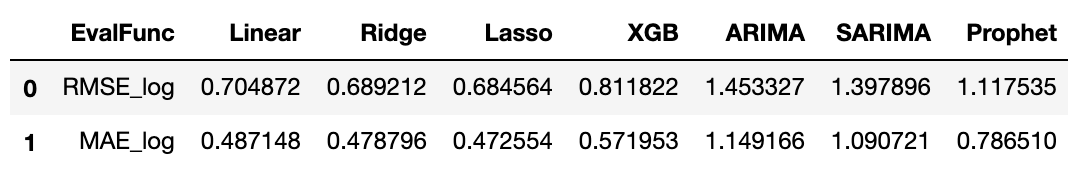

In [86]:
# Evalation for the prediction of validation data based on original
Eval_table_original

,EvalFunc,Linear,Ridge,Lasso,XGB,ARIMA,SARIMA
0,RMSE_Yen/kWh,3.012834,3.015317,2.921191,3.466605,2.874347,5.075235
1,MAE_Yen/kWh,1.600463,1.600490,1.534332,1.919109,1.522968,2.855110


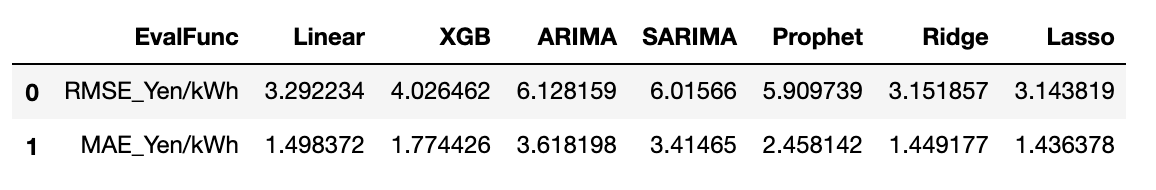

In [ ]:
all_data["Close"][Min_valid_index:].describe()

Target
- Mean: 6.693
- Std; 5.888

※
[Explanable easily but conservative]
Linear model
ARIMA, ARIMAX, etc
Prophet

